In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from astropy.time import Time
from gaussian_process_example import *

In [33]:
from astropy.coordinates import Distance
import astropy.units as u
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    try:
        z = float(z)
    except:
        if type(z) == str:
            z = float(z.split('±')[0])
            #print('converted')
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        #print(z)
        #print(type(z))
        if z<=0:
            d = 8178*u.pc ## https://ui.adsabs.harvard.edu/abs/2019A%26A...625L..10G/abstract
        elif z > 0:
            d = Distance(unit=u.pc, z=float(z), allow_negative=True)
        try:
            M = m - 5 * np.log10(d/(10*u.pc))
        except:
            M = np.nan
        return M
absmag = np.vectorize(absmag)

In [34]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)
df_eval = pd.read_csv('candidateEval02-16-25.csv')
# df_eval['redshift'] = df_eval['redshift'].apply(lambda x: float(x.split('±')[0]) if '±' in x else float(x))
# df_eval.to_csv('candidateEval07-18.csv', index=False)
# df_eval = df_eval.dropna(subset=["redshift"]).copy().reset_index(drop=True)

objIds = sorted(list(set(df_eval["object"])))

In [35]:
for i, row in enumerate(df_eval.itertuples()):
    z = row.redshift
    if z is None or z is np.nan:
        continue
    elif type(z) == str:
        z = float(z.split('±')[0])
    df_eval.at[i, 'redshift'] = z
        

In [36]:
data_folder = 'data/'
photometry_dict = {}


for root, dirs, files in sorted(os.walk(data_folder)):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)
        elif file == 'AT2017gfo_reduced.dat': ## importing AT2017gfo photometry
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            photometry_dict[folder_name] = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None, names=['isot', 'filter', 'mag', 'magerr'])

lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}
## remove empty lightcurves
lc_dict = {key: val for key, val in lc_dict.items() if not val.empty}

##doing stuff for AT2017gfo
filter_dict = {"ps1::g":"ztfg", "ps1::r":"ztfr", "ps1::i":"ztfi"}
lc_dict['AT2017gfo']['mjd'] = lc_dict['AT2017gfo']['isot'].apply(lambda x: Time(x).mjd)
lc_dict['AT2017gfo']['snr'] =  1 / lc_dict['AT2017gfo']['magerr'] ## estimation, not used for anything really
for i, row in lc_dict['AT2017gfo'].iterrows():
    if row['filter'] in filter_dict:
        lc_dict['AT2017gfo'].at[i, 'filter'] = filter_dict[row['filter']]
## drop if it is not in the filter dict
lc_dict['AT2017gfo'] = lc_dict['AT2017gfo'][lc_dict['AT2017gfo']['filter'].isin(filter_dict.values())]
lc_dict['AT2017gfo']['obj_id'] = 'AT2017gfo'

In [37]:
display(lc_dict['AT2017gfo'])

isot filter    mag  magerr        mjd         snr  \
0    2017-08-18T05:32:38.400   ztfi  17.24    0.06  57983.231   16.666667   
3    2017-08-18T10:04:48.000   ztfg  17.46    0.08  57983.420   12.500000   
4    2017-08-18T10:04:48.000   ztfr  17.32    0.07  57983.420   14.285714   
5    2017-08-18T10:04:48.000   ztfi  17.42    0.05  57983.420   20.000000   
6    2017-08-18T18:11:31.200   ztfg  18.05    0.12  57983.758    8.333333   
7    2017-08-18T18:11:31.200   ztfr  17.89    0.03  57983.758   33.333333   
11   2017-08-18T23:15:21.600   ztfg  18.49    0.04  57983.969   25.000000   
12   2017-08-18T23:15:21.600   ztfr  17.99    0.01  57983.969  100.000000   
13   2017-08-18T23:15:21.600   ztfi  17.85    0.05  57983.969   20.000000   
20   2017-08-19T05:32:38.400   ztfi  17.87    0.06  57984.231   16.666667   
23   2017-08-19T08:52:48.000   ztfg  19.28    0.17  57984.370    5.882353   
24   2017-08-19T08:52:48.000   ztfr  18.34    0.11  57984.370    9.090909   
25   2017-08-19T08:52:48.000   ztfi  18.32    0.14  57984.370    7.142857   
26   2017-08-19T18:15:50.400   ztfg  19.87    0.21  57984.761    4.761905   
27   2017-08-19T18:15:50.400   ztfr  18.80    0.07  57984.761   14.285714   
28   2017-08-19T18:15:50.400   ztfi  18.30    0.15  57984.761    6.666667   
34   2017-08-19T23:15:21.600   ztfg  20.19    0.11  57984.969    9.090909   
35   2017-08-19T23:15:21.600   ztfr  19.13    0.17  57984.969    5.882353   
36   2017-08-19T23:15:21.600   ztfi  18.58    0.04  57984.969   25.000000   
42   2017-08-20T05:32:38.400   ztfi  18.44    0.09  57985.231   11.111111   
45   2017-08-20T09:07:12.000   ztfg  20.43    0.16  57985.380    6.250000   
46   2017-08-20T09:07:12.000   ztfr  19.34    0.09  57985.380   11.111111   
47   2017-08-20T09:07:12.000   ztfi  18.62    0.07  57985.380   14.285714   
48   2017-08-20T18:37:26.400   ztfr  19.64    0.13  57985.776    7.692308   
49   2017-08-20T18:37:26.400   ztfi  18.80    0.20  57985.776    5.000000   
54   2017-08-20T23:22:33.600   ztfg  21.13    0.16  57985.974    6.250000   
55   2017-08-20T23:22:33.600   ztfr  19.81    0.02  57985.974   50.000000   
56   2017-08-20T23:22:33.600   ztfi  19.03    0.01  57985.974  100.000000   
62   2017-08-21T05:39:50.400   ztfi  17.80     inf  57986.236    0.000000   
65   2017-08-21T17:02:24.000   ztfr  20.30    0.31  57986.710    3.225806   
69   2017-08-21T23:22:33.600   ztfg  21.58    0.22  57986.974    4.545455   
70   2017-08-21T23:22:33.600   ztfr  20.53    0.05  57986.974   20.000000   
71   2017-08-21T23:22:33.600   ztfi  19.51    0.04  57986.974   25.000000   
77   2017-08-22T23:31:12.000   ztfr  20.79    0.24  57987.980    4.166667   
78   2017-08-22T23:31:12.000   ztfi  19.55    0.18  57987.980    5.555556   
81   2017-08-23T23:45:36.000   ztfg  22.08    0.52  57988.990    1.923077   
82   2017-08-23T23:45:36.000   ztfr  20.95    0.35  57988.990    2.857143   
86   2017-08-25T00:00:00.000   ztfg  23.28    0.34  57990.000    2.941176   
87   2017-08-25T00:00:00.000   ztfr  21.23    0.11  57990.000    9.090909   
88   2017-08-25T00:00:00.000   ztfi  20.54    0.05  57990.000   20.000000   
94   2017-08-26T00:00:00.000   ztfr  21.95    0.18  57991.000    5.555556   
95   2017-08-26T00:00:00.000   ztfi  20.72    0.06  57991.000   16.666667   
101  2017-08-27T00:00:00.000   ztfr  22.20    0.04  57992.000   25.000000   
102  2017-08-27T00:00:00.000   ztfi  21.37    0.06  57992.000   16.666667   

        obj_id  
0    AT2017gfo  
3    AT2017gfo  
4    AT2017gfo  
5    AT2017gfo  
6    AT2017gfo  
7    AT2017gfo  
11   AT2017gfo  
12   AT2017gfo  
13   AT2017gfo  
20   AT2017gfo  
23   AT2017gfo  
24   AT2017gfo  
25   AT2017gfo  
26   AT2017gfo  
27   AT2017gfo  
28   AT2017gfo  
34   AT2017gfo  
35   AT2017gfo  
36   AT2017gfo  
42   AT2017gfo  
45   AT2017gfo  
46   AT2017gfo  
47   AT2017gfo  
48   AT2017gfo  
49   AT2017gfo  
54   AT2017gfo  
55   AT2017gfo  
56   AT2017gfo  
62   AT2017gfo  
65   AT2017gfo  
69   AT2017gfo  
70   AT2017gfo

<Axes: xlabel='mjd', ylabel='mag'>

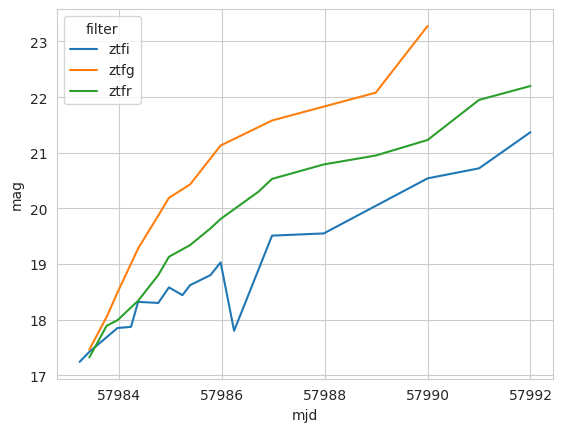

In [38]:
sns.lineplot(data=lc_dict['AT2017gfo'], x='mjd', y='mag', hue='filter')

Compile all the objects into one dataframe, with the following columns:
- `id`: the object id
- `class`: the object class
- `redshift`: the redshift of the object
- `mjd`: time of observation
- `mag`: the magnitude of the object
- `mag_err`: the error of the magnitude
- `filter`: the filter of the observation

In [39]:
df_objects = pd.DataFrame(columns=['obj_id', 'type', 'redshift', 'mjd', 'mag', 'magerr', 'filter', 'snr'])

for obj_id in objIds:
    df_lc = lc_dict[obj_id]
    df_lc.dropna(subset=['mag', 'magerr'], inplace=True)
    df_lc['id'] = obj_id
    df_lc = df_lc[['obj_id', 'mjd', 'mag', 'magerr', 'filter', 'snr']]
    df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
    df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
    df_objects = pd.concat([df_objects, df_lc])

/tmp/ipykernel_3467/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
/tmp/ipykernel_3467/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
/tmp/ipykernel_3467/982688885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [40]:
df_objects = df_objects[(df_objects['filter'] == 'ztfr') | (df_objects['filter'] == 'ztfg') | (df_objects['filter'] == 'ztfi')]
df_objects = df_objects[df_objects['snr']>5]

In [41]:
df_objects_norm = pd.DataFrame()
df_objects_norm['obj_id'] = df_objects['obj_id']
df_objects_norm['type'] = df_objects['type']
df_objects_norm['redshift'] = df_objects['redshift']
df_objects_norm['mjd'] = df_objects['mjd']
df_objects_norm['mag'] = df_objects['mag']
df_objects_norm['magerr'] = df_objects['magerr']
df_objects_norm['filter'] = df_objects['filter']
df_objects_norm['mjd_0'] = df_objects.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
df_objects_norm['t'] = df_objects.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))
df_objects_norm['absmag'] = absmag(df_objects['mag'], df_objects['redshift'])
display(df_objects_norm)
#df_objects_norm.to_csv('gp_objects_original_observations.csv', index=False)

obj_id      type  redshift           mjd        mag    magerr  \
0      AT2017gfo  Kilonova   0.00984  57983.231000  17.240000  0.060000   
3      AT2017gfo  Kilonova   0.00984  57983.420000  17.460000  0.080000   
4      AT2017gfo  Kilonova   0.00984  57983.420000  17.320000  0.070000   
5      AT2017gfo  Kilonova   0.00984  57983.420000  17.420000  0.050000   
6      AT2017gfo  Kilonova   0.00984  57983.758000  18.050000  0.120000   
..           ...       ...       ...           ...        ...       ...   
87  ZTF24abvevzs       IIb   0.03500  60650.533484  19.486008  0.068334   
90  ZTF24abvevzs       IIb   0.03500  60652.490127  20.068013  0.170292   
91  ZTF24abvevzs       IIb   0.03500  60652.490127  20.068001  0.170292   
92  ZTF24abvevzs       IIb   0.03500  60652.491644  20.109029  0.140443   
94  ZTF24abvevzs       IIb   0.03500  60652.538137  19.863190  0.129076   

   filter         mjd_0         t     absmag  
0    ztfi  57983.231000  0.000000 -15.973680  
3    ztfg  57983.231000  0.189000 -15.753680  
4    ztfr  57983.231000  0.189000 -15.893680  
5    ztfi  57983.231000  0.189000 -15.793680  
6    ztfg  57983.231000  0.527000 -15.163680  
..    ...           ...       ...        ...  
87   ztfg  60646.432303  4.101181 -16.523548  
90   ztfg  60646.432303  6.057824 -15.941543  
91   ztfg  60646.432303  6.057824 -15.941555  
92   ztfg  60646.432303  6.059340 -15.900527  
94   ztfr  60646.432303  6.105833 -16.146366  

[9433 rows x 10 columns]

In [42]:
df_objects_matched = pd.DataFrame(columns=['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',])

for row in df_objects_norm.itertuples():
    obj_id = row.obj_id
    mjd = row.mjd
    t = row.t
    mag = row.mag
    magerr = row.magerr
    filter = row.filter
    absmag_ = row.absmag
    abs_label = 'abs_mag_' + filter
    mag_label = 'mag_' + filter
    magerr_label = 'mag_error_' + filter
    
    df_objects_matched = pd.concat([df_objects_matched, pd.DataFrame([{'obj_id': obj_id, 'type': row.type, 'redshift': row.redshift, 'mjd': mjd, 'mjd_0': row.mjd_0, 't': t, mag_label: mag, abs_label: absmag_, magerr_label: magerr}])], ignore_index=True)
display(df_objects_matched)



obj_id      type  redshift           mjd         mjd_0         t  \
0        AT2017gfo  Kilonova   0.00984  57983.231000  57983.231000  0.000000   
1        AT2017gfo  Kilonova   0.00984  57983.420000  57983.231000  0.189000   
2        AT2017gfo  Kilonova   0.00984  57983.420000  57983.231000  0.189000   
3        AT2017gfo  Kilonova   0.00984  57983.420000  57983.231000  0.189000   
4        AT2017gfo  Kilonova   0.00984  57983.758000  57983.231000  0.527000   
...            ...       ...       ...           ...           ...       ...   
9428  ZTF24abvevzs       IIb   0.03500  60650.533484  60646.432303  4.101181   
9429  ZTF24abvevzs       IIb   0.03500  60652.490127  60646.432303  6.057824   
9430  ZTF24abvevzs       IIb   0.03500  60652.490127  60646.432303  6.057824   
9431  ZTF24abvevzs       IIb   0.03500  60652.491644  60646.432303  6.059340   
9432  ZTF24abvevzs       IIb   0.03500  60652.538137  60646.432303  6.105833   

       mag_ztfg  abs_mag_ztfg  mag_error_ztfg  mag_ztfr  abs_mag_ztfr  \
0           NaN           NaN             NaN       NaN           NaN   
1     17.460000    -15.753680        0.080000       NaN           NaN   
2           NaN           NaN             NaN  17.32000    -15.893680   
3           NaN           NaN             NaN       NaN           NaN   
4     18.050000    -15.163680        0.120000       NaN           NaN   
...         ...           ...             ...       ...           ...   
9428  19.486008    -16.523548        0.068334       NaN           NaN   
9429  20.068013    -15.941543        0.170292       NaN           NaN   
9430  20.068001    -15.941555        0.170292       NaN           NaN   
9431  20.109029    -15.900527        0.140443       NaN           NaN   
9432        NaN           NaN             NaN  19.86319    -16.146366   

      mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi  
0                NaN     17.24     -15.97368            0.06  
1                NaN       NaN           NaN             NaN  
2           0.070000       NaN           NaN             NaN  
3                NaN     17.42     -15.79368            0.05  
4                NaN       NaN           NaN             NaN  
...              ...       ...           ...             ...  
9428             NaN       NaN           NaN             NaN  
9429             NaN       NaN           NaN             NaN  
9430             NaN       NaN           NaN             NaN  
9431             NaN       NaN           NaN             NaN  
9432        0.129076       NaN           NaN             NaN  

[9433 rows x 15 columns]

In [43]:
df_objects_matched.to_csv('gp_objects_original_observations(matched).csv', index=False)

In [44]:
df_objects[df_objects['type'] == 'Novae']

obj_id   type  redshift           mjd        mag    magerr filter  \
274  ZTF20acgigfo  Novae   0.00017  59124.288357  18.381100  0.083481   ztfr   
275  ZTF20acgigfo  Novae   0.00017  59124.288357  18.381100  0.083481   ztfr   
276  ZTF20acgigfo  Novae   0.00017  59125.327755  17.792999  0.048662   ztfr   
277  ZTF20acgigfo  Novae   0.00017  59125.327755  17.792999  0.048662   ztfr   
284  ZTF20acgigfo  Novae   0.00017  59126.343403  17.543400  0.041242   ztfr   
..            ...    ...       ...           ...        ...       ...    ...   
206  ZTF23abrzabc  Novae       NaN  60327.191678  19.246989  0.117960   ztfr   
207  ZTF23abrzabc  Novae       NaN  60327.191678  19.247000  0.117960   ztfr   
208  ZTF23abrzabc  Novae       NaN  60327.248854  19.389191  0.208391   ztfg   
12   ZTF23absafzo  Novae   0.00000  60284.239167  18.961108  0.129392   ztfi   
13   ZTF23absafzo  Novae   0.00000  60287.119583  19.386442  0.097783   ztfr   

           snr  
274  13.005788  
275  13.005788  
276  22.311788  
277  22.311788  
284  26.325984  
..         ...  
206   9.204309  
207   9.204274  
208   5.210092  
12    8.391053  
13   11.103522  

[659 rows x 8 columns]

In [45]:
df_objects[df_objects['magerr'] < 0]

Empty DataFrame
Columns: [obj_id, type, redshift, mjd, mag, magerr, filter, snr]
Index: []

In [46]:
def Mag2Flux(df):
    df_copy = df.dropna().copy()
    df_copy['flux'] = 10 ** (-0.4 * (df_copy['mag'] - 23.9))
    df_copy['flux_error'] = (df_copy['magerr'] / (2.5 / np.log(10))) * df_copy['flux']

    df_copy = df_copy[['obj_id', 'mjd', 'flux', 'flux_error', 'filter', 'type', 'redshift']]
    return df_copy

def Normalize(df):
    df_copy = df.dropna().copy()
    df_copy['mjd_0'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
    df_copy['mjd'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))

    df_copy.reset_index(drop=True, inplace=True)
    return df_copy


In [47]:
flux_df = Mag2Flux(df_objects)
flux_df = flux_df.dropna(subset=['flux', 'flux_error']).copy()
norm_df = Normalize(flux_df)


In [48]:
flux_df['obj_id'].unique()

array(['AT2017gfo', 'ZTF18aakuewf', 'ZTF18aalrxas', 'ZTF18abffyqp',
       'ZTF18abvkmgw', 'ZTF18abwkrbl', 'ZTF19aanbpus', 'ZTF19aapfmki',
       'ZTF19aatesgp', 'ZTF19abacxod', 'ZTF19abxjrge', 'ZTF19abxtcio',
       'ZTF19abyjzvd', 'ZTF19acbumks', 'ZTF19accjfgv', 'ZTF20aahfqpm',
       'ZTF20aajnksq', 'ZTF20aaxhzhc', 'ZTF20aayrobw', 'ZTF20aazchcq',
       'ZTF20abstsxb', 'ZTF20aburywx', 'ZTF20abwysqy', 'ZTF20abwzqzo',
       'ZTF20acgigfo', 'ZTF20acgiglu', 'ZTF20acigusw', 'ZTF20aclfmwn',
       'ZTF20acozryr', 'ZTF20acqntkr', 'ZTF20actqnhg', 'ZTF21aaabrpu',
       'ZTF21aaabwfu', 'ZTF21aabxjqr', 'ZTF21aagwbjr', 'ZTF21aapkbav',
       'ZTF21aaqzrat', 'ZTF21abbvvmf', 'ZTF21abexegc', 'ZTF21abfmpwn',
       'ZTF21abhywxv', 'ZTF21aciosfu', 'ZTF22aaajecp', 'ZTF22aabjpxh',
       'ZTF22aahgvlx', 'ZTF22aaibbvy', 'ZTF22aajrrzz', 'ZTF22aayluxo',
       'ZTF22aazmooy', 'ZTF22abfjnpj', 'ZTF22abfxmpc', 'ZTF22abijszk',
       'ZTF22abmsaxp', 'ZTF22abntkbk', 'ZTF22abuzpzz', 'ZTF22acaruqr',
       'Z

In [49]:
long_objects = norm_df[norm_df.groupby('obj_id')['mjd'].transform('max') > 50]['obj_id'].unique()

# fig, ax = plt.subplots()
# sns.lineplot(data=norm_df[norm_df['obj_id'].isin(long_objects)][norm_df['mjd']<50][norm_df['obj_id']!='ZTF22abfjnpj'], x='mjd', y='flux', hue='obj_id', ax=ax)

In [50]:
def count_obj_by_type(df):
    obj_id_count_per_type = df.groupby('type')['obj_id'].nunique()
    print(obj_id_count_per_type)

In [51]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(norm_df, groups=norm_df['obj_id']))

train_data = norm_df.iloc[train_idx]
test_data = norm_df.iloc[test_idx]

In [52]:
# count_obj_by_type(train_data)
# count_obj_by_type(test_data)
count_obj_by_type(norm_df)

type
Afterglow       9
Cataclysmic    10
FBOT            2
II              8
IIP             1
IIb            21
Ia              5
Ib              3
Ib/c;Ib-pec     1
Ibn             3
Ic-BL           1
Kilonova        1
Novae           9
TDE             1
Name: obj_id, dtype: int64


In [53]:
pb_wavelengths = {
    'ztfg': 4800.,
    'ztfr': 6400.,
    'ztfi': 7900.,
} 
## Note for future reference: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Palomar/ZTF.g

filters = ['ztfg', 'ztfr', 'ztfi']

gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)

inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items()}

# These functions are taken from the 'Paying Attention to Astronomical Transients' paper

def fit_2d_gp(obj_data, kernel=None, return_kernel=False, global_fit=False, **kwargs):
    if kernel is None:
        guess_length_scale = 20.0
        signal_to_noises = np.abs(obj_data.flux) / np.sqrt(
            obj_data.flux_error ** 2 + (1e-2 * np.max(obj_data.flux)) ** 2
        )
        scale = np.abs(obj_data.flux[signal_to_noises.idxmax()])
        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
            guess_length_scale ** 2, 6000 ** 2], ndim=2)
        kernel.freeze_parameter("k2:metric:log_M_1_1")


    obj_times = obj_data.mjd.astype(float)
    obj_flux = obj_data.flux.astype(float)
    obj_flux_error = obj_data.flux_error.astype(float)
    obj_wavelengths = obj_data['filter'].map(pb_wavelengths)

    def neg_log_like(p):  # Objective function: negative log-likelihood
        gp.set_parameter_vector(p)
        loglike = gp.log_likelihood(obj_flux, quiet=True)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(p):  # Gradient of the objective function.
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(obj_flux, quiet=True)

    gp = george.GP(kernel)
    default_gp_param = gp.get_parameter_vector()
    x_data = np.vstack([obj_times, obj_wavelengths]).T
    gp.compute(x_data, obj_flux_error)

    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(default_gp_param[0] - 10, default_gp_param[0] + 10)] + bounds
    results = op.minimize(neg_log_like, gp.get_parameter_vector(),
                          jac=grad_neg_log_like, method="L-BFGS-B",
                          bounds=bounds, tol=1e-6)

    if results.success:
        gp.set_parameter_vector(results.x)
    else:
        # Fit failed. Print out a warning, and use the initial guesses for fit
        # parameters.
        obj = obj_data['obj_id'][0]
        print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
        gp.set_parameter_vector(default_gp_param)

    gp_predict = partial(gp.predict, obj_flux)

    if return_kernel:
        return kernel, gp_predict
    else:
        return gp_predict


def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : pandas.core.frame.DataFrame, optional
        Time, flux and flux error of the fitted Gaussian Process.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred, np.sqrt(pb_pred_var)))
        obj_gp_pb = Table(
            [
                obj_gp_pb_array[:, 0],
                obj_gp_pb_array[:, 1],
                obj_gp_pb_array[:, 2],
                [wavelength] * number_gp,
            ],
            names=["mjd", "flux", "flux_error", "filter"],
        )
        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = vstack((obj_gps, obj_gp_pb))
            
    obj_gps = obj_gps.to_pandas()
    return obj_gps

def process_gaussian(df, kernel=None, number_gp=100, save=False, name=''):
    
    res_df = pd.DataFrame()

    for obj_id in tqdm.tqdm(df['obj_id'].unique()):
        obj_df = df[df['obj_id'] == obj_id]
        type_obj = obj_df['type'].values[0]
        mjd_0 = obj_df['mjd_0'].values[0]
        redshift = obj_df['redshift'].values[0]
        obj_df.reset_index(drop=True, inplace=True)

        available_filters = obj_df['filter'].unique()
        gp_wavelengths = np.vectorize(pb_wavelengths.get)(available_filters)
        inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items() if k in available_filters}
        gp_predict = fit_2d_gp(obj_df, kernel=kernel)
        gp_times = np.linspace(min(obj_df['mjd']), max(obj_df['mjd']), number_gp)

        obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)
        obj_gps['filter'] = obj_gps['filter'].map(inverse_gp_wavelengths)

        obj_gps = obj_gps.pivot_table(index=['mjd'], columns='filter', values=['flux', 'flux_error'])
        obj_gps = obj_gps.reset_index()
        obj_gps.columns = [col[0] if col[0] == 'mjd' else '_'.join(col).strip() for col in obj_gps.columns.values]
        obj_gps['type'] = type_obj
        obj_gps['obj_id'] = obj_id
        obj_gps['mjd_0'] = mjd_0
        obj_gps['redshift'] = redshift

        res_df = pd.concat([res_df, obj_gps])

    res_df.reset_index(drop=True, inplace=True)

    if save:
        #types_str = '_'.join(df['type'].unique()) if hasattr(df['type'].unique(), '__iter__') else str(df['type'].unique())
        #filename = f'{name}_gp_{types_str}.csv'
        num_types_str = str(len(df['type'].unique()))
        filename = f'{name}_gp_n{num_types_str}.csv'
        filename = filename.replace(' ', '_')
        res_df.to_csv(filename, index=False)
        print(f'File {filename} saved successfully')
    return res_df

def save_kernel(kernel, filename):
    with open(filename, 'wb') as f:
        pickle.dump(kernel, f)
    print(f'Kernel saved to {filename}')

def load_kernel(filename):
    with open(filename, 'rb') as f:
        kernel = pickle.load(f)
    print(f'Kernel loaded from {filename}')
    return kernel

In [54]:
kernel = load_kernel('kernel.pkl')

Kernel loaded from kernel.pkl


In [55]:
# test_results = process_gaussian(test_data, kernel=kernel, save=True, name='test')
# train_results = process_gaussian(train_data, kernel=kernel, save=True, name='train')
total_results = process_gaussian(norm_df[norm_df['mjd']<50], kernel=kernel, save=False, name='total', number_gp=1000)

100%|██████████| 75/75 [00:08<00:00,  9.04it/s]


In [56]:
total_results[total_results['obj_id'] == 'ZTF24abvevzs']

mjd  flux_ztfg  flux_ztfi  flux_ztfr  flux_error_ztfg  \
73001  0.000000  36.331010        NaN  25.066002         2.034971   
73002  0.006112  36.878915        NaN  25.505385         1.897780   
73003  0.012224  37.431393        NaN  25.949203         1.804559   
73004  0.018336  37.987503        NaN  26.397472         1.755290   
73005  0.024448  38.546301        NaN  26.850209         1.748509   
...         ...        ...        ...        ...              ...   
73996  6.081386  33.493383        NaN  40.961798         3.488673   
73997  6.087498  33.463261        NaN  40.930338         3.842217   
73998  6.093610  33.432509        NaN  40.895906         4.235472   
73999  6.099721  33.401076        NaN  40.858402         4.657035   
74000  6.105833  33.368917        NaN  40.817727         5.098662   

       flux_error_ztfi  flux_error_ztfr type        obj_id         mjd_0  \
73001              NaN         3.157210  IIb  ZTF24abvevzs  60646.432303   
73002              NaN         2.788540  IIb  ZTF24abvevzs  60646.432303   
73003              NaN         2.448082  IIb  ZTF24abvevzs  60646.432303   
73004              NaN         2.151762  IIb  ZTF24abvevzs  60646.432303   
73005              NaN         1.923001  IIb  ZTF24abvevzs  60646.432303   
...                ...              ...  ...           ...           ...   
73996              NaN         5.252959  IIb  ZTF24abvevzs  60646.432303   
73997              NaN         5.054402  IIb  ZTF24abvevzs  60646.432303   
73998              NaN         4.909244  IIb  ZTF24abvevzs  60646.432303   
73999              NaN         4.823773  IIb  ZTF24abvevzs  60646.432303   
74000              NaN         4.802653  IIb  ZTF24abvevzs  60646.432303   

       redshift  
73001     0.035  
73002     0.035  
73003     0.035  
73004     0.035  
73005     0.035  
...         ...  
73996     0.035  
73997     0.035  
73998     0.035  
73999     0.035  
74000     0.035  

[1000 rows x 11 columns]

In [62]:
color_dict = {'ztfg': 'blue', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    #color_dict = {'ztfg': 'blue', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time Since First Detection [days]')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'{obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)
    ax.grid()
    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd':
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['mjd'], obj_model[column], label=f'{filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['mjd'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [63]:
total_results

mjd   flux_ztfg   flux_ztfi   flux_ztfr  flux_error_ztfg  \
0      0.000000  385.374906  440.341788  404.940209        29.250027   
1      0.008778  382.559484  438.232033  402.502588        28.789575   
2      0.017556  379.738177  436.119876  400.065220        28.332873   
3      0.026333  376.910979  434.005567  397.628148        27.879986   
4      0.035111  374.077886  431.889351  395.191413        27.430981   
...         ...         ...         ...         ...              ...   
73996  6.081386   33.493383         NaN   40.961798         3.488673   
73997  6.087498   33.463261         NaN   40.930338         3.842217   
73998  6.093610   33.432509         NaN   40.895906         4.235472   
73999  6.099721   33.401076         NaN   40.858402         4.657035   
74000  6.105833   33.368917         NaN   40.817727         5.098662   

       flux_error_ztfi  flux_error_ztfr      type        obj_id         mjd_0  \
0            17.182907        24.797305  Kilonova     AT2017gfo  57983.231000   
1            16.890215        24.361032  Kilonova     AT2017gfo  57983.231000   
2            16.606597        23.927709  Kilonova     AT2017gfo  57983.231000   
3            16.332054        23.497397  Kilonova     AT2017gfo  57983.231000   
4            16.066587        23.070161  Kilonova     AT2017gfo  57983.231000   
...                ...              ...       ...           ...           ...   
73996              NaN         5.252959       IIb  ZTF24abvevzs  60646.432303   
73997              NaN         5.054402       IIb  ZTF24abvevzs  60646.432303   
73998              NaN         4.909244       IIb  ZTF24abvevzs  60646.432303   
73999              NaN         4.823773       IIb  ZTF24abvevzs  60646.432303   
74000              NaN         4.802653       IIb  ZTF24abvevzs  60646.432303   

       redshift  
0       0.00984  
1       0.00984  
2       0.00984  
3       0.00984  
4       0.00984  
...         ...  
73996   0.03500  
73997   0.03500  
73998   0.03500  
73999   0.03500  
74000   0.03500  

[74001 rows x 11 columns]

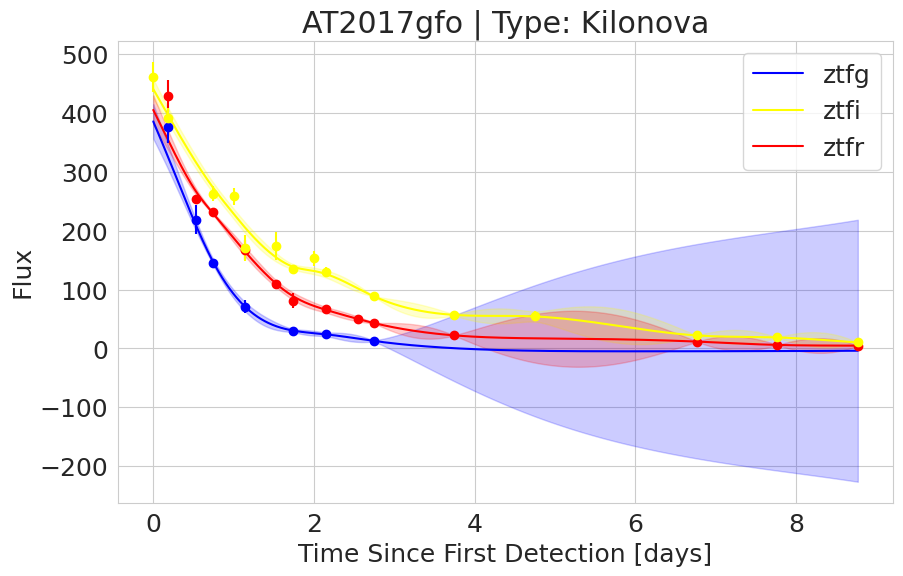

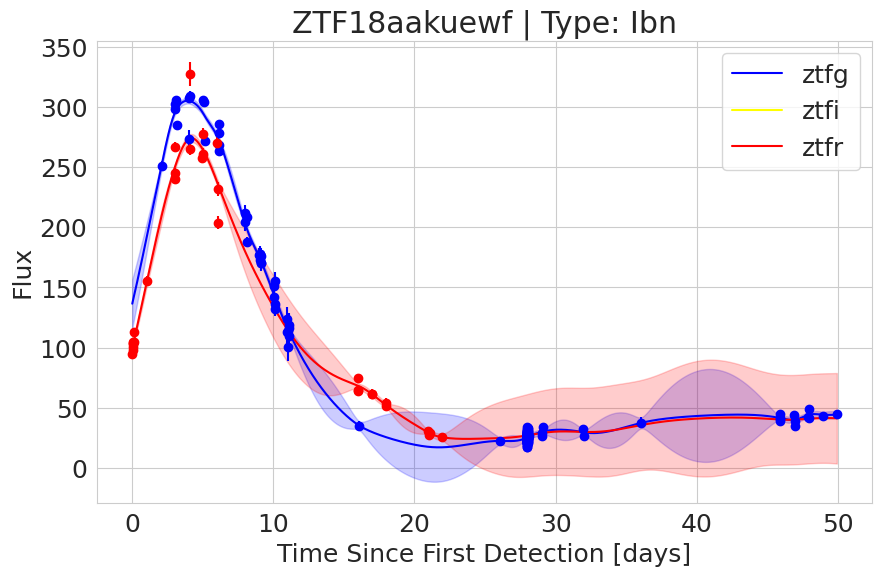

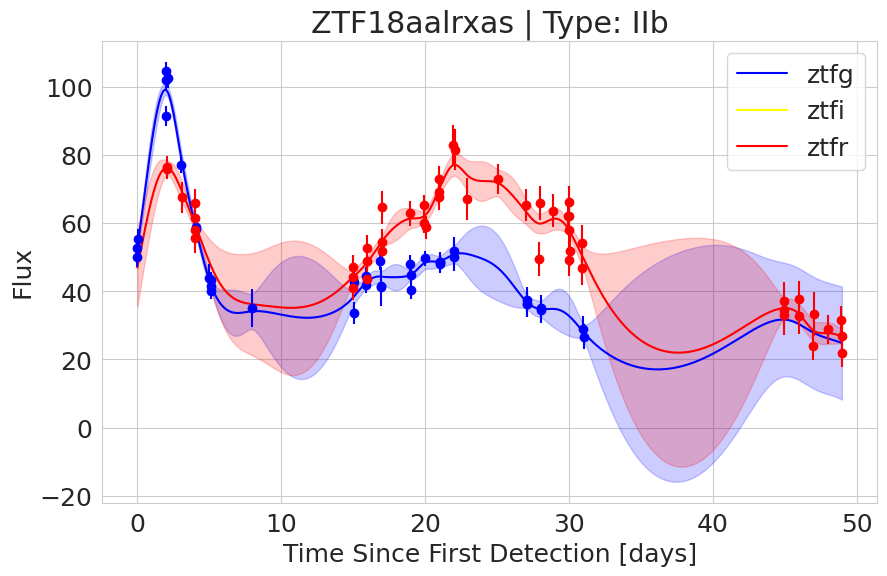

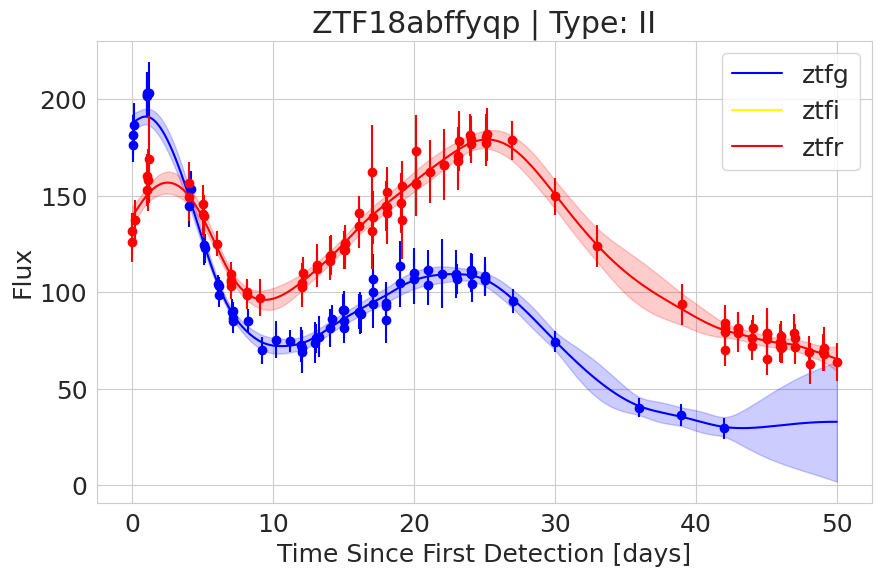

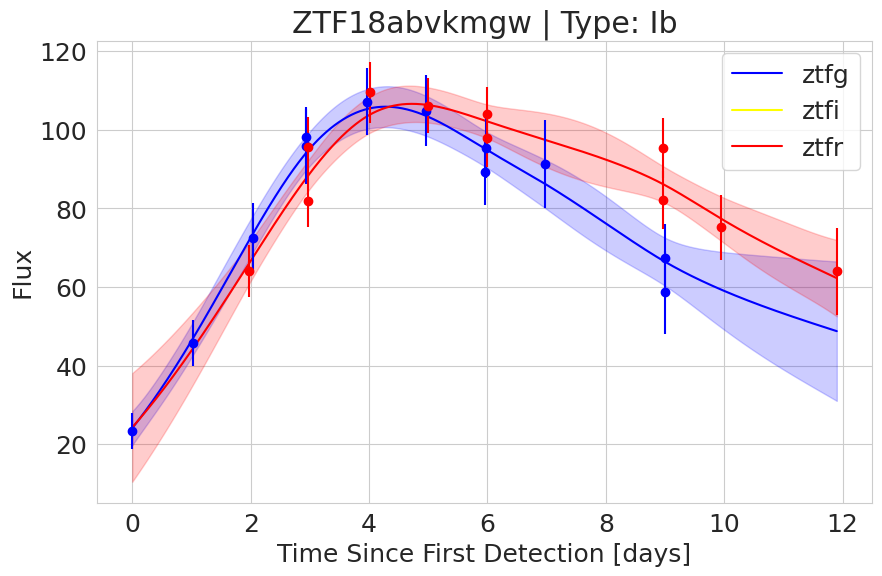

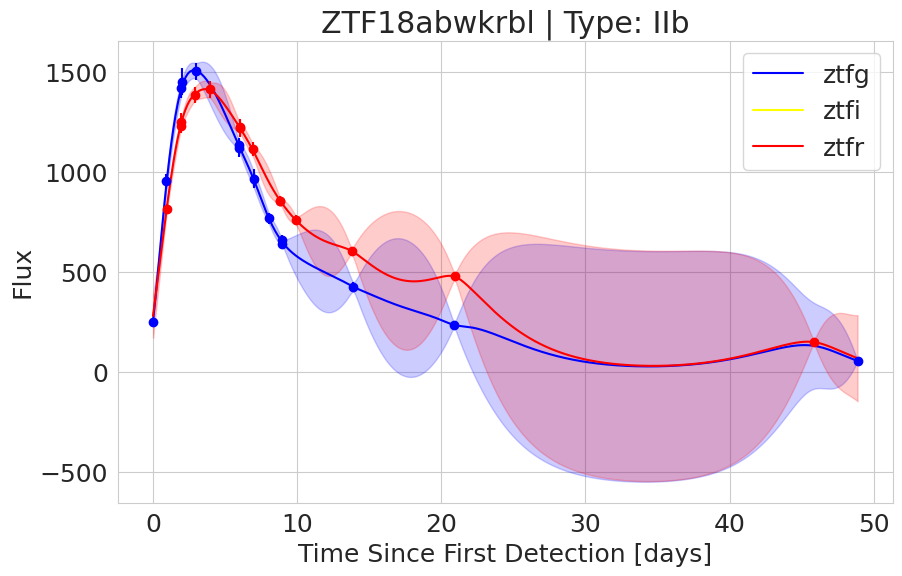

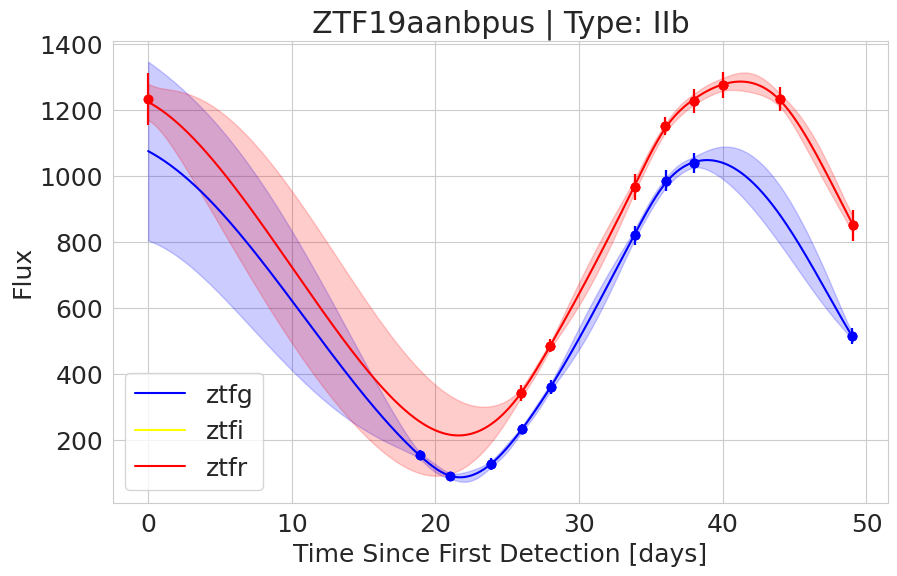

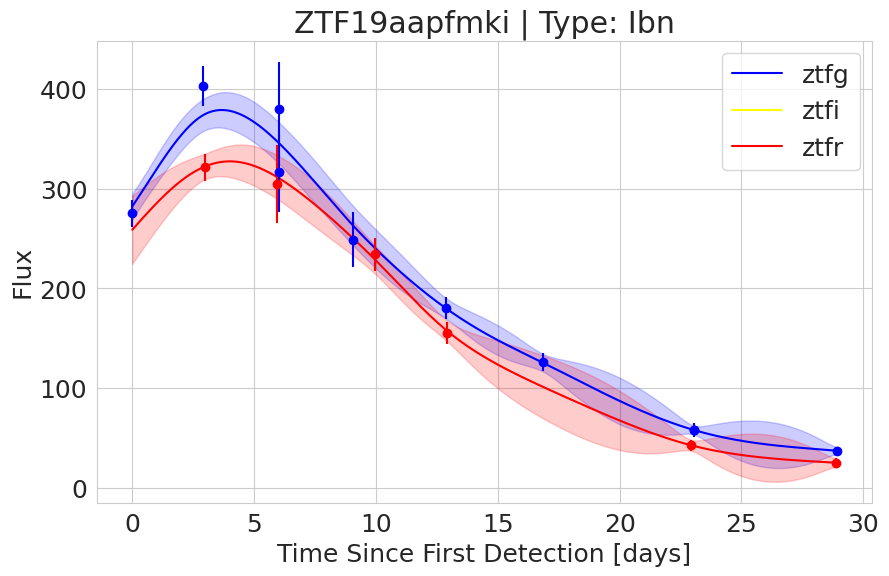

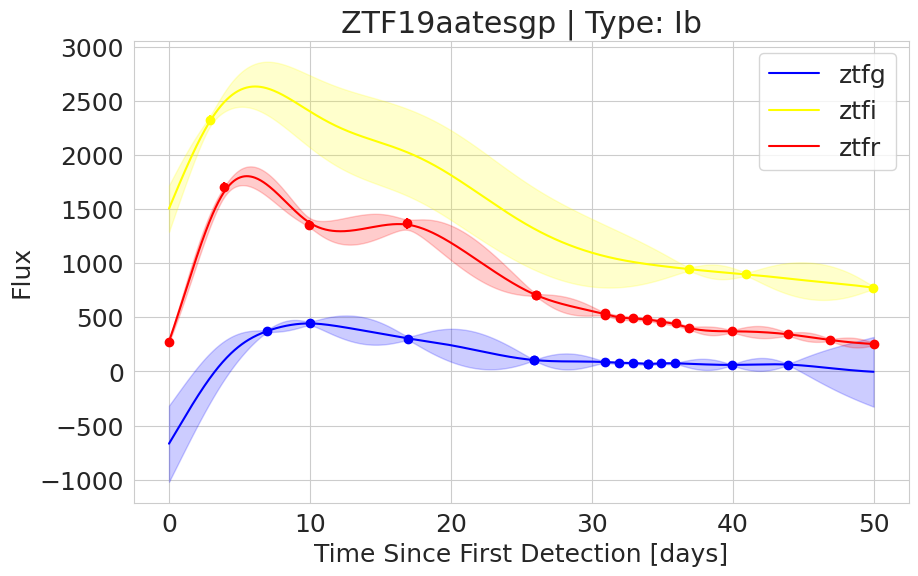

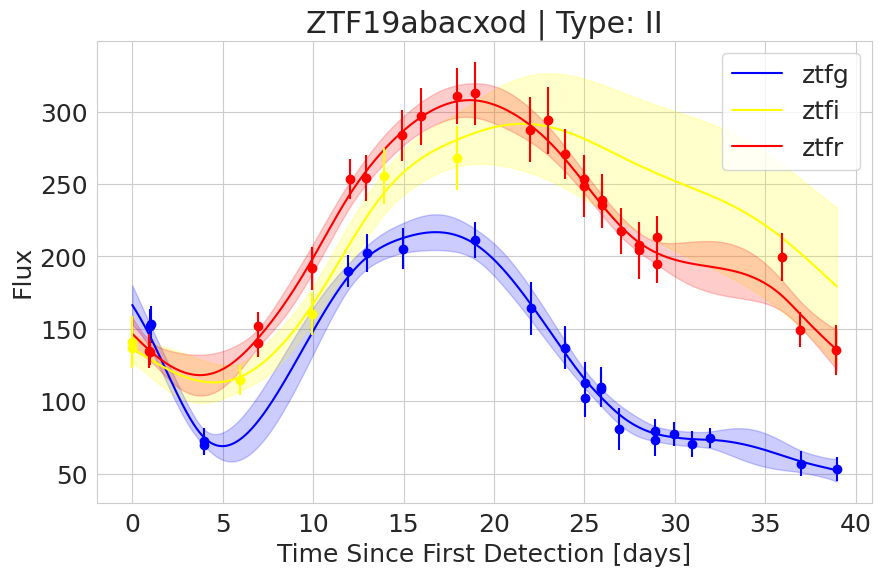

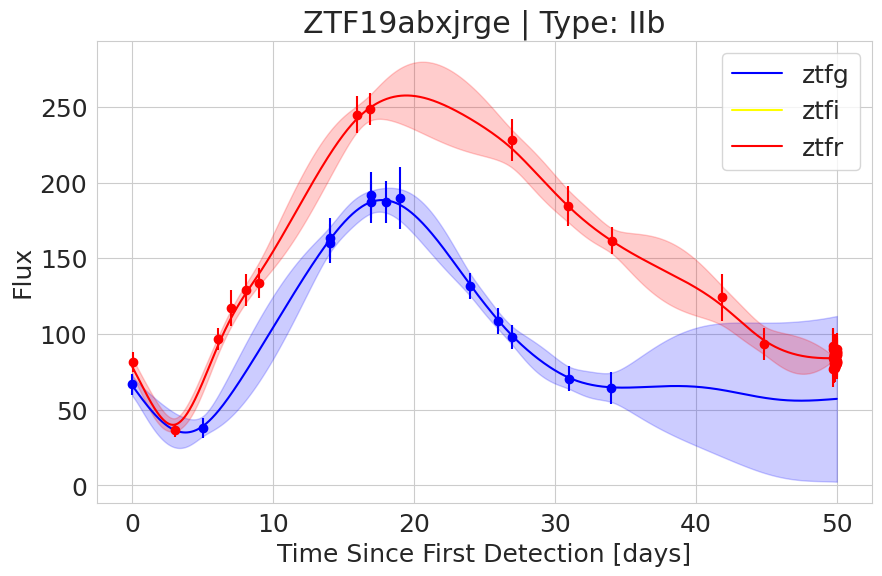

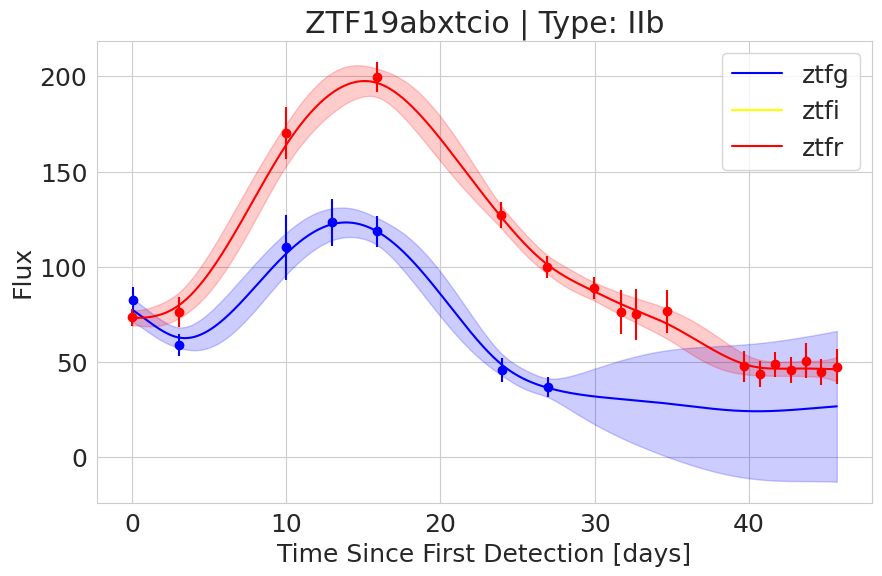

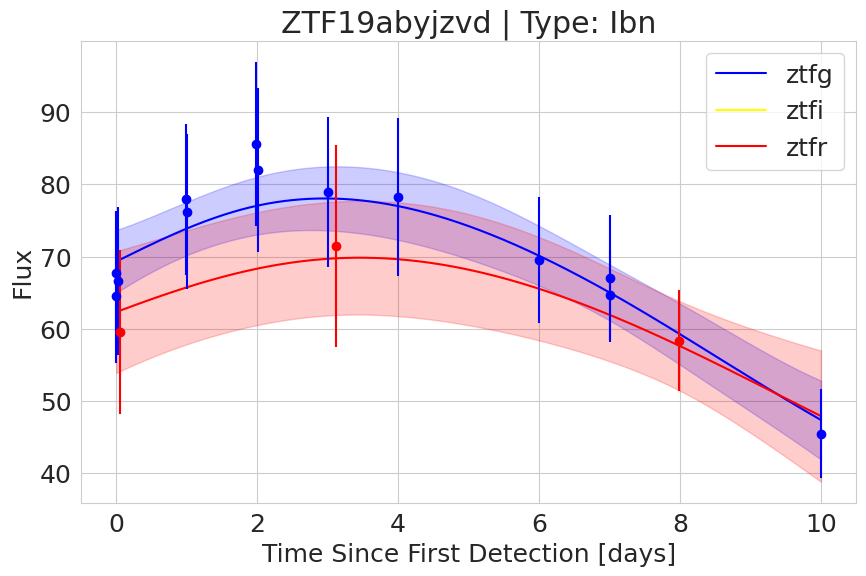

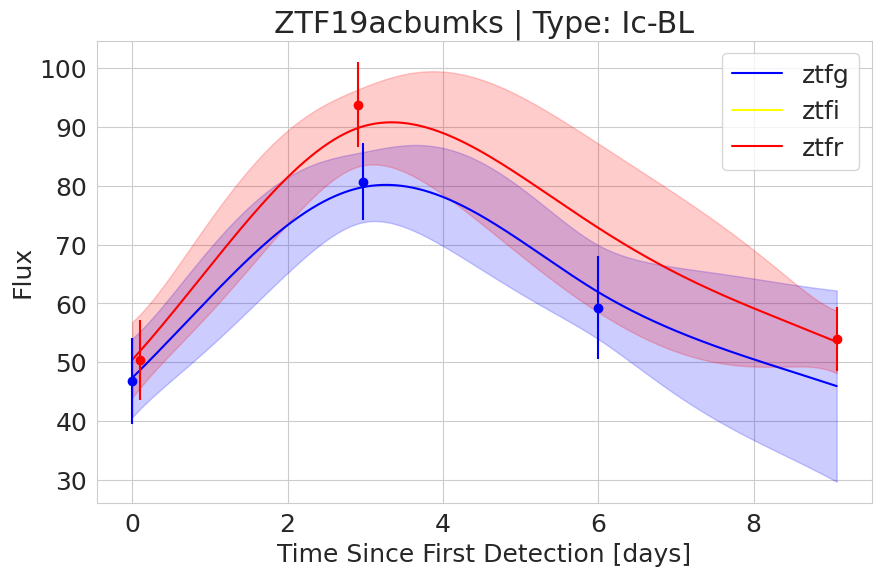

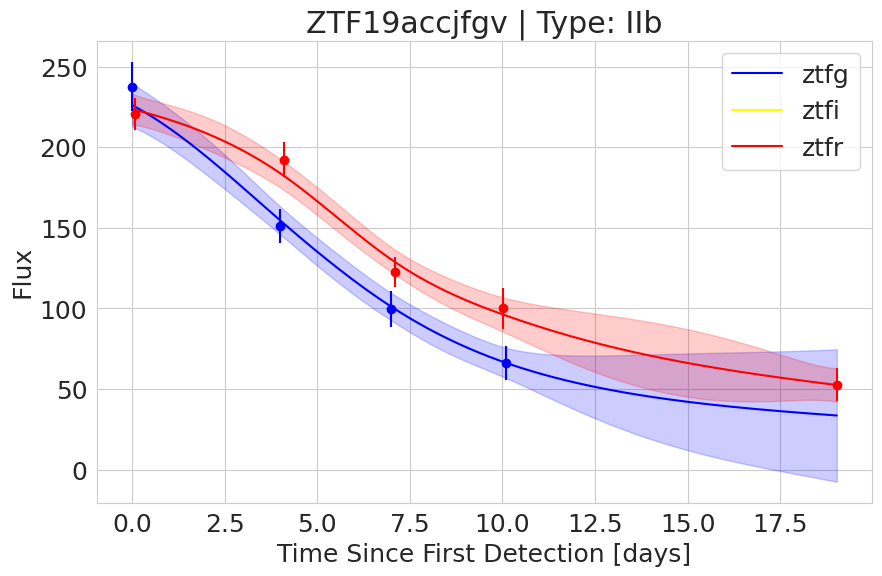

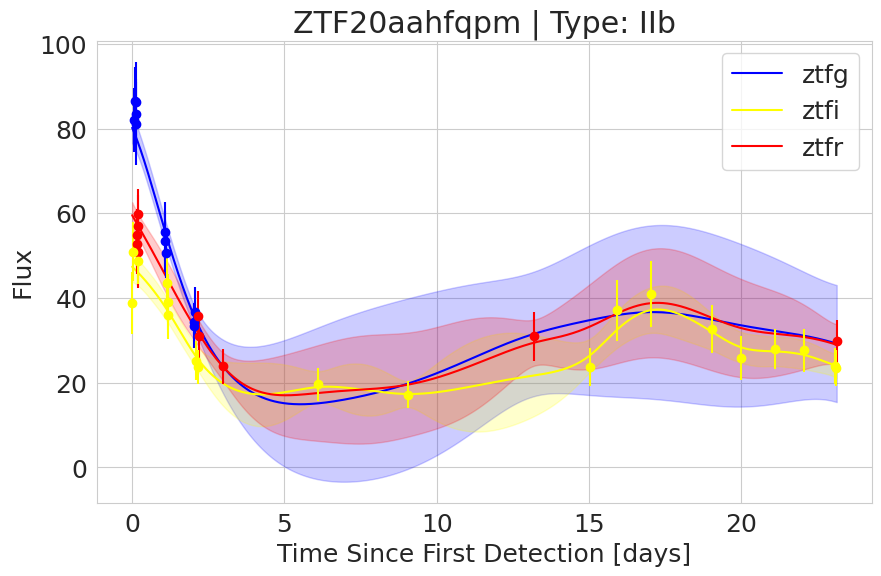

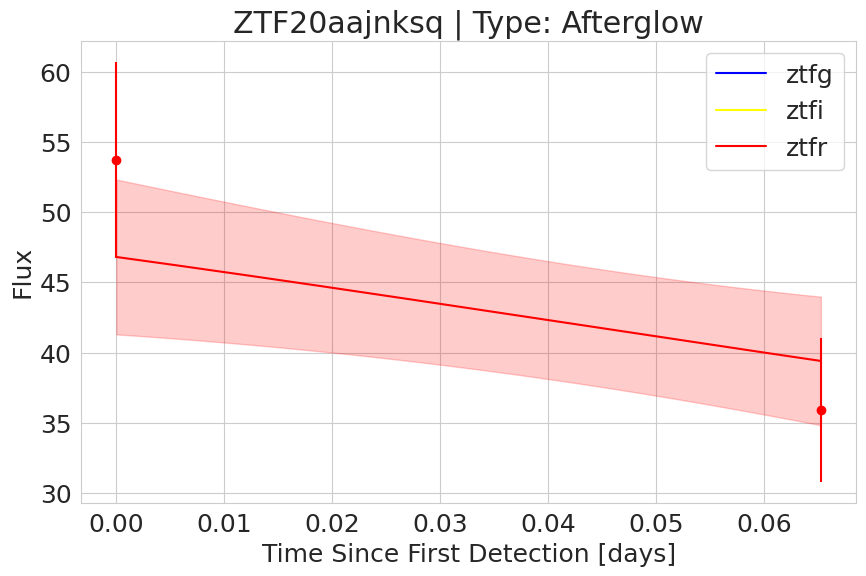

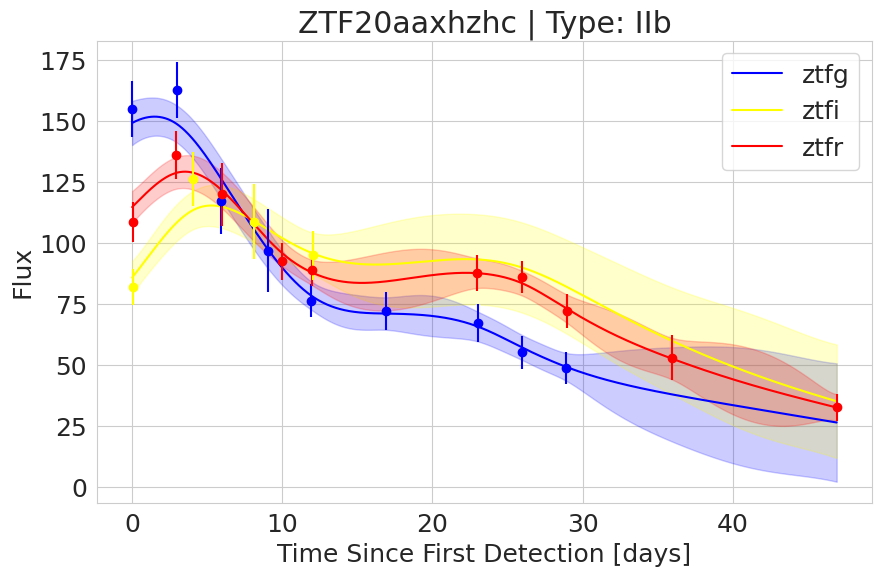

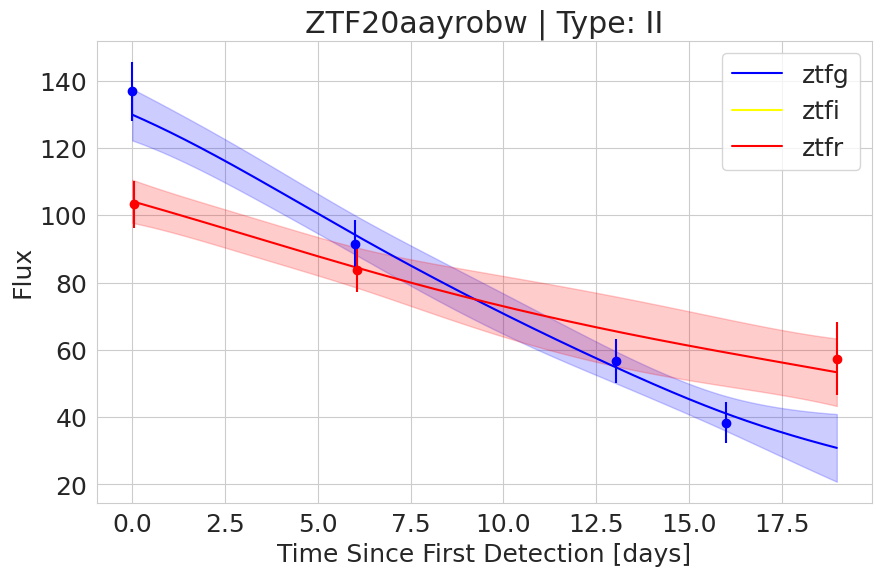

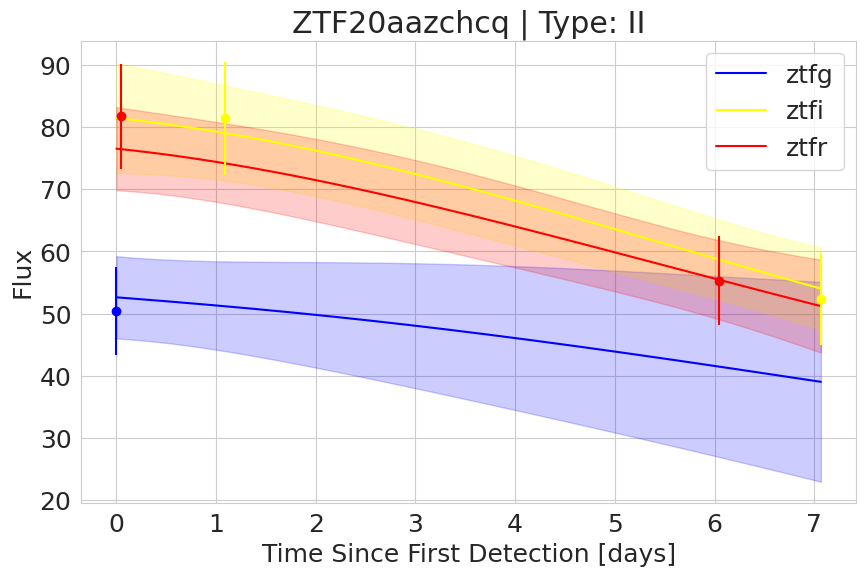

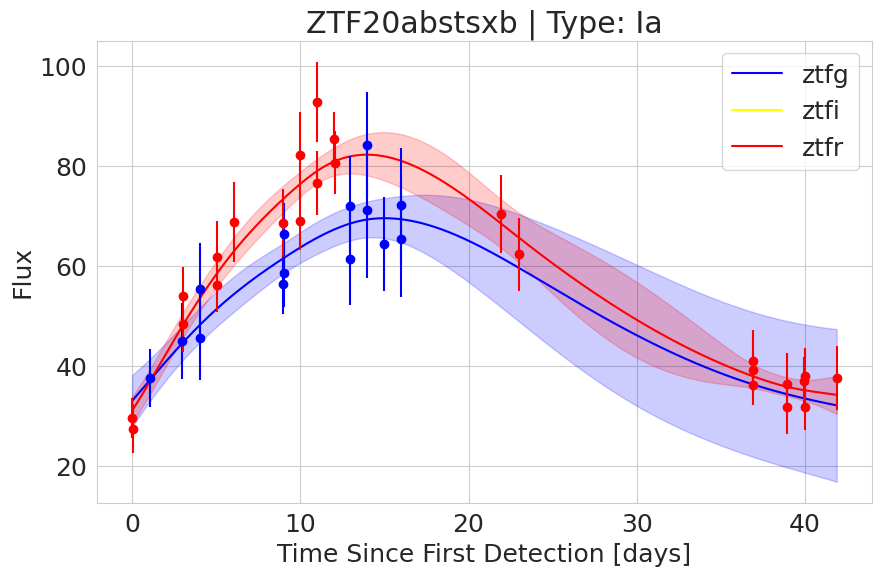

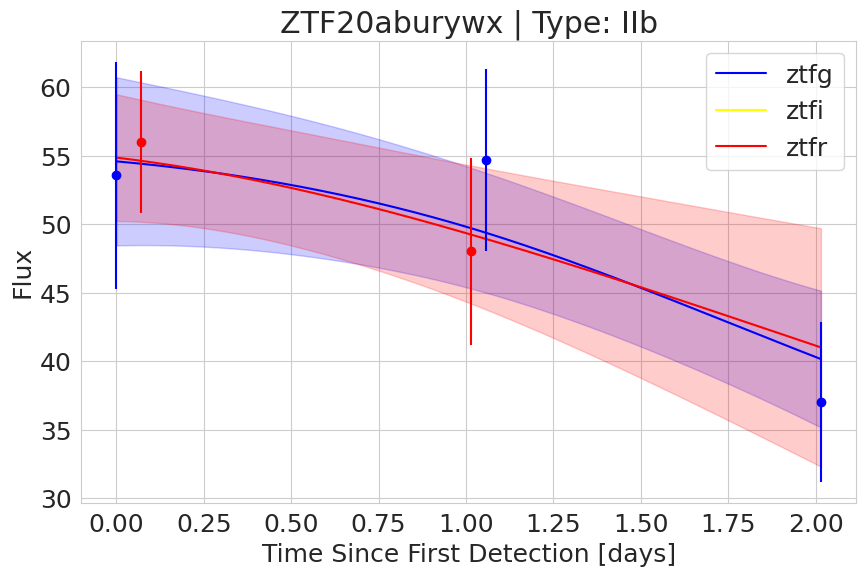

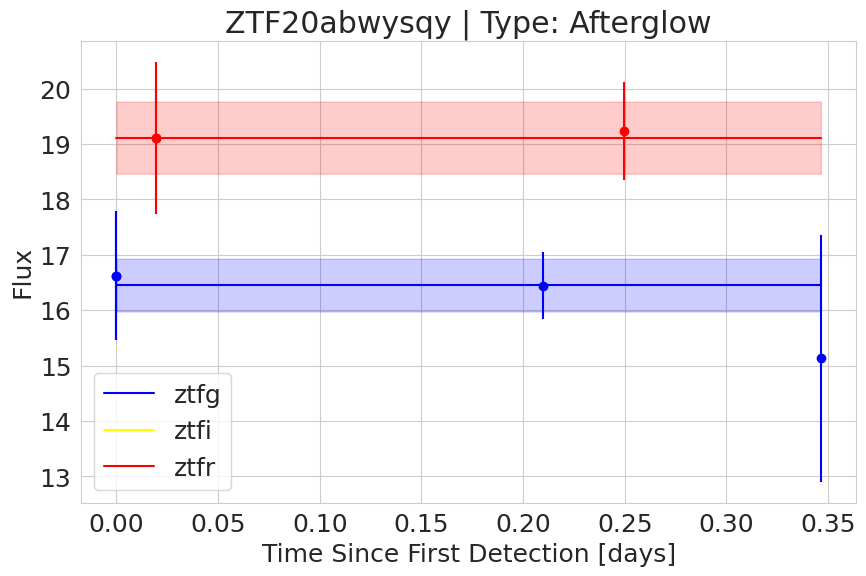

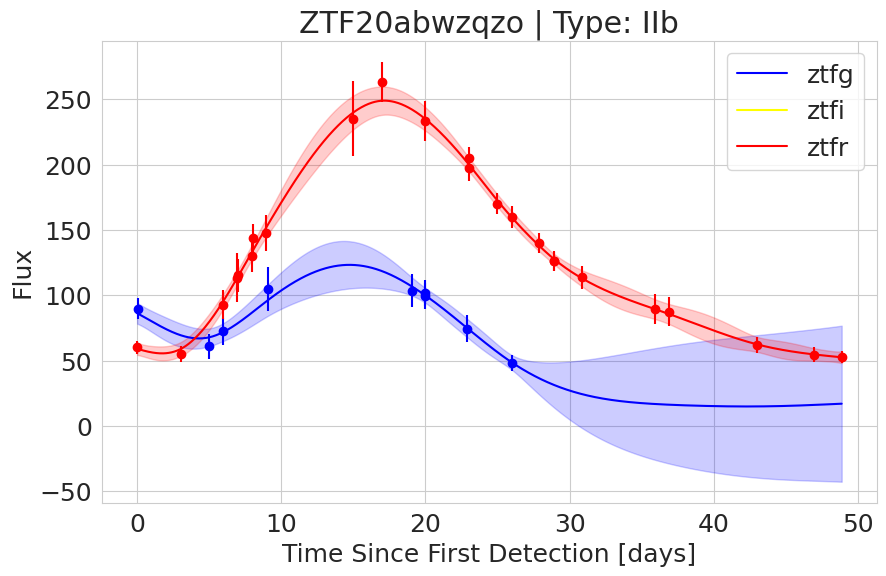

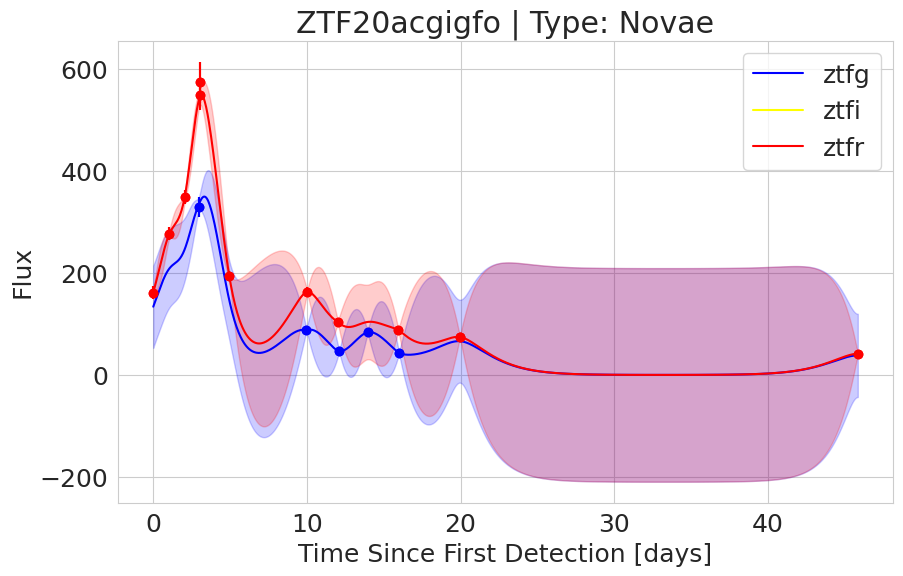

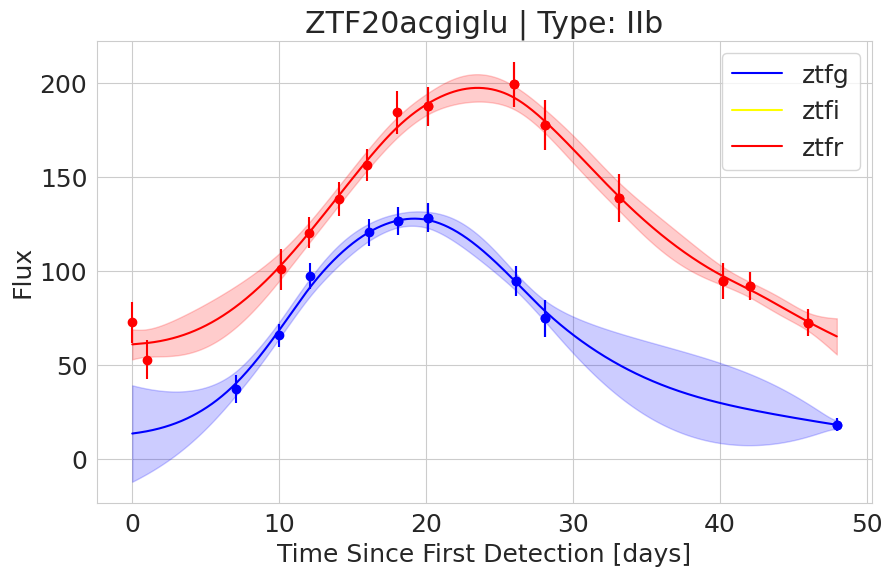

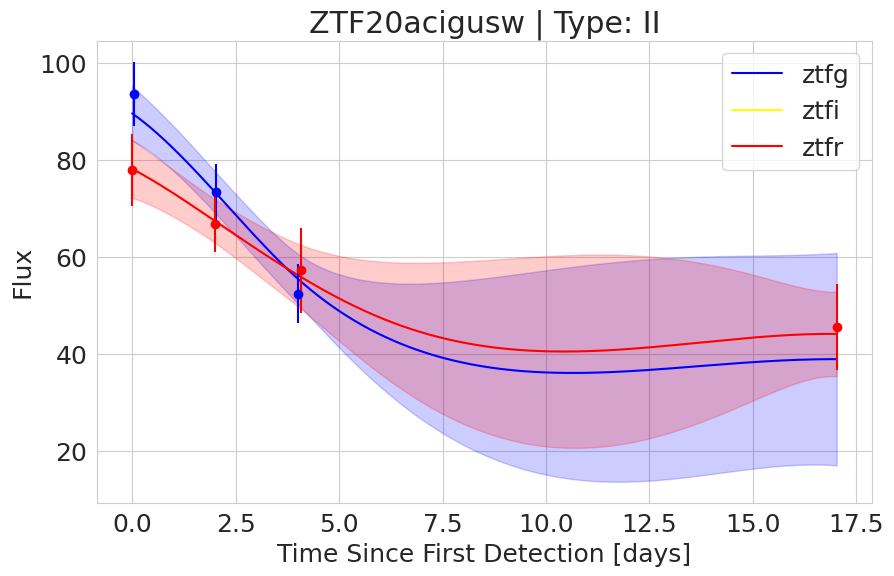

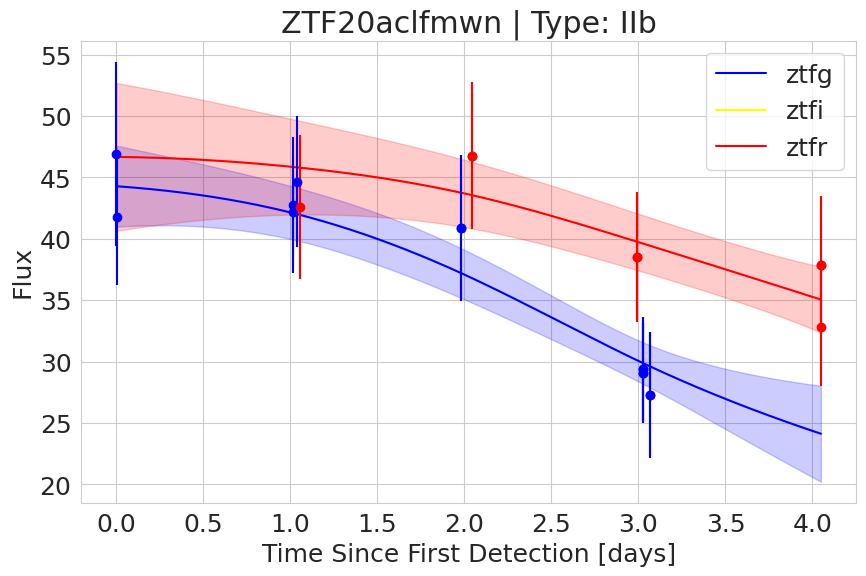

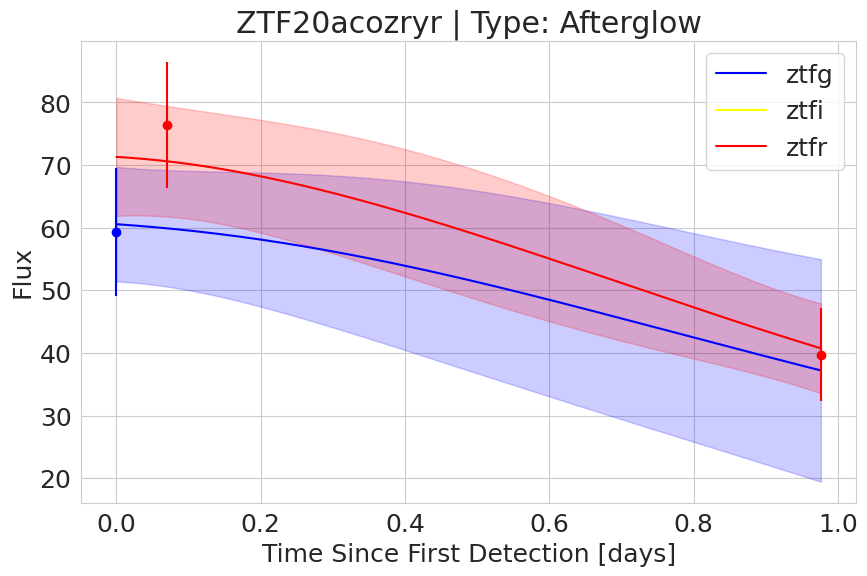

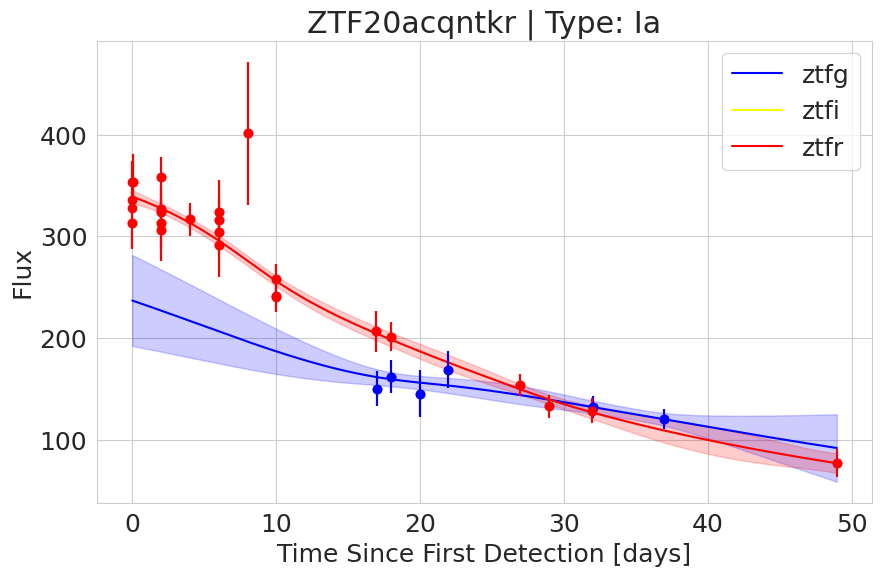

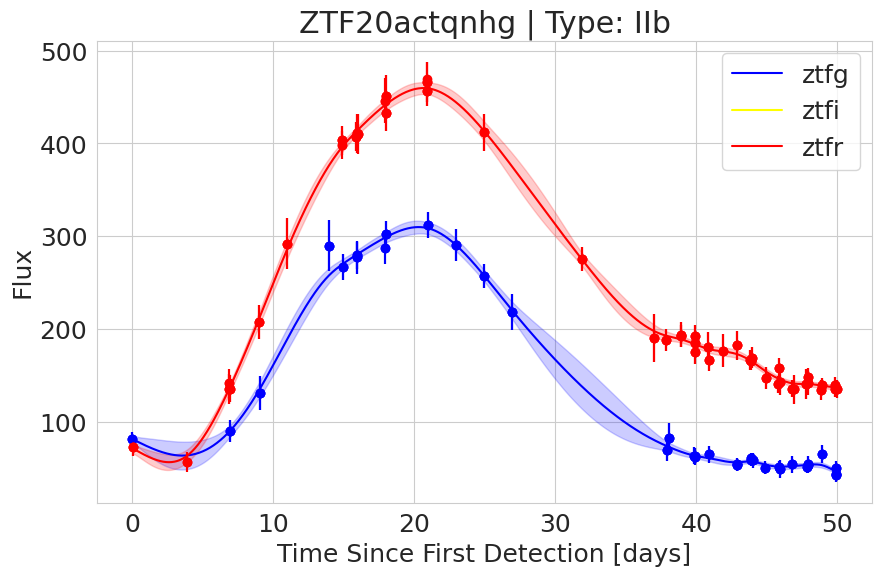

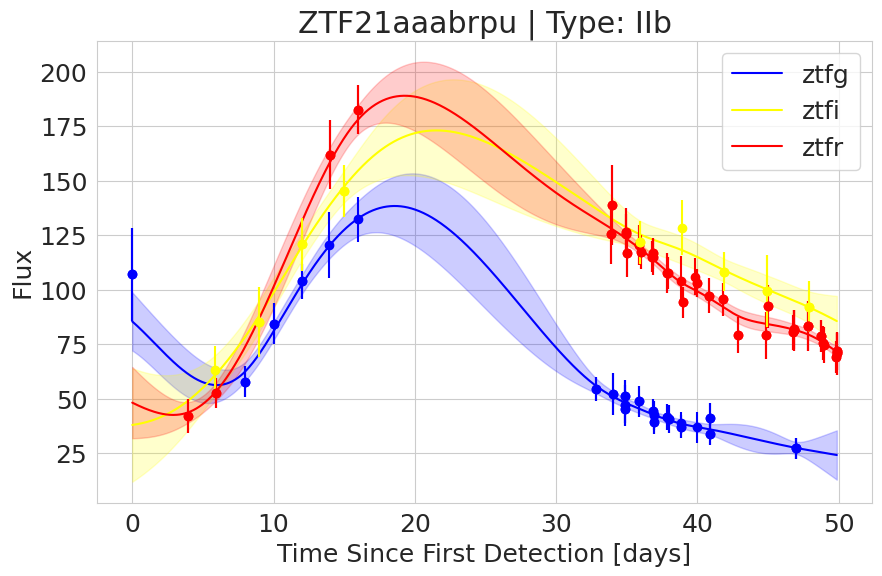

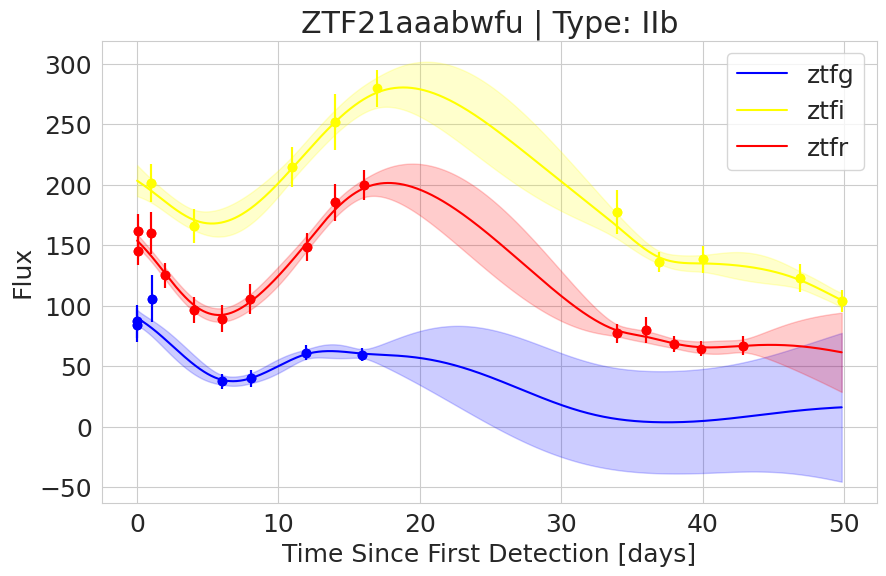

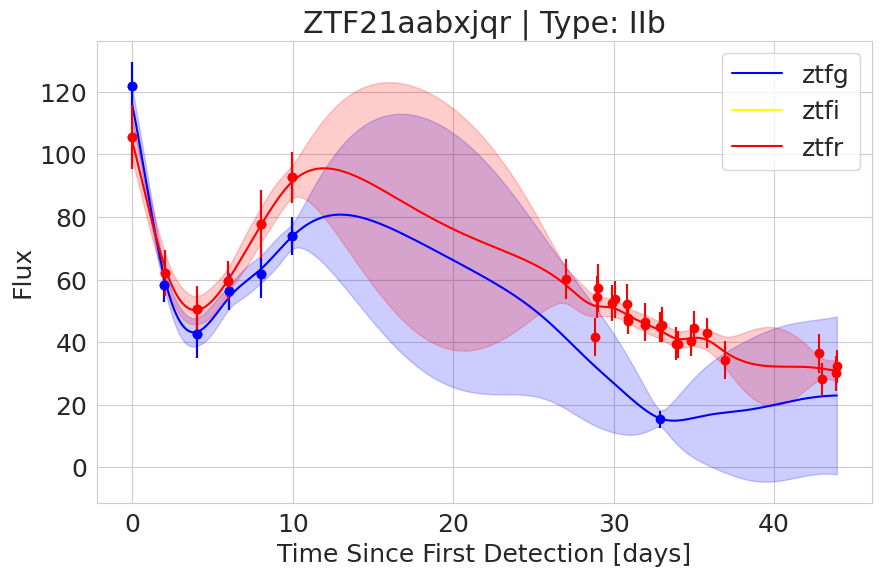

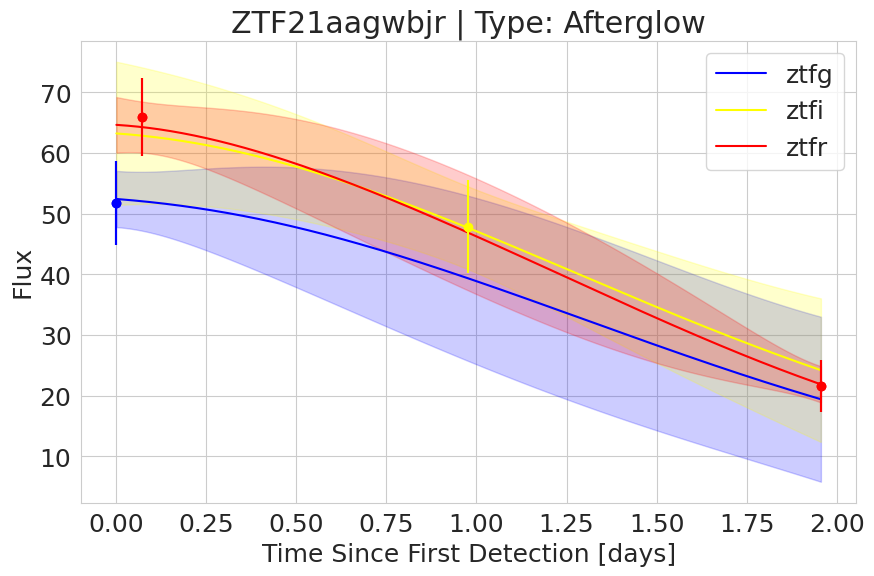

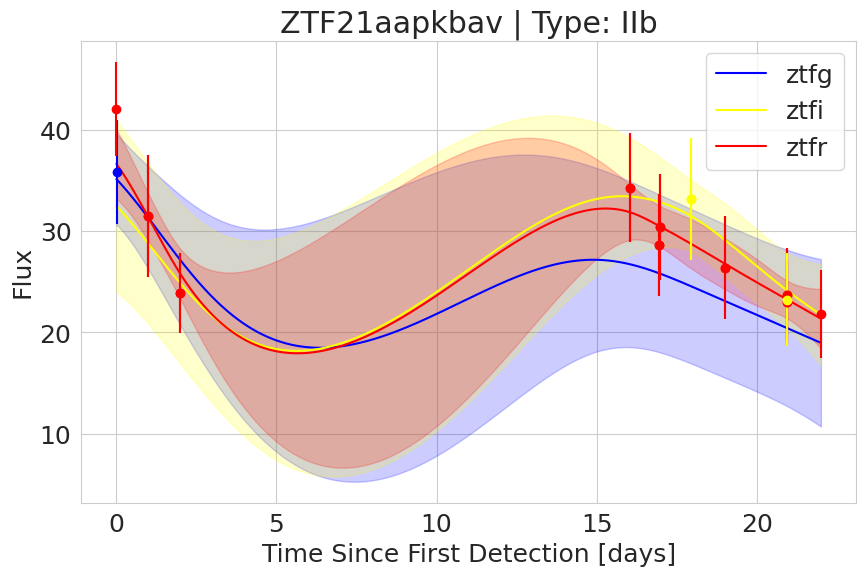

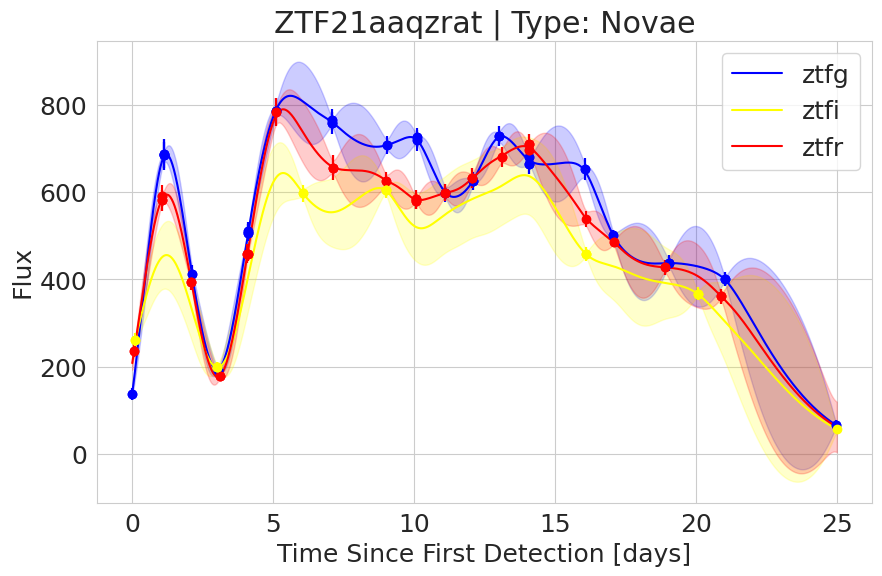

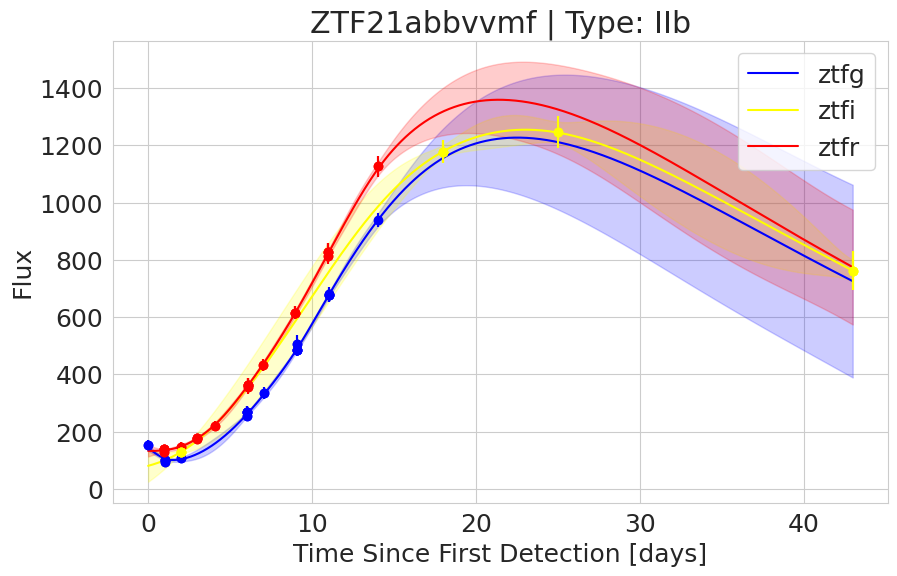

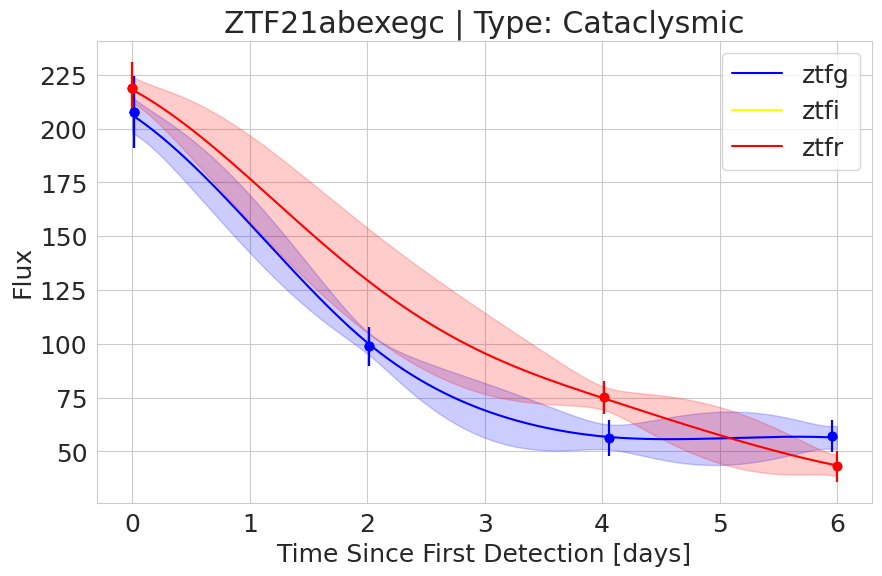

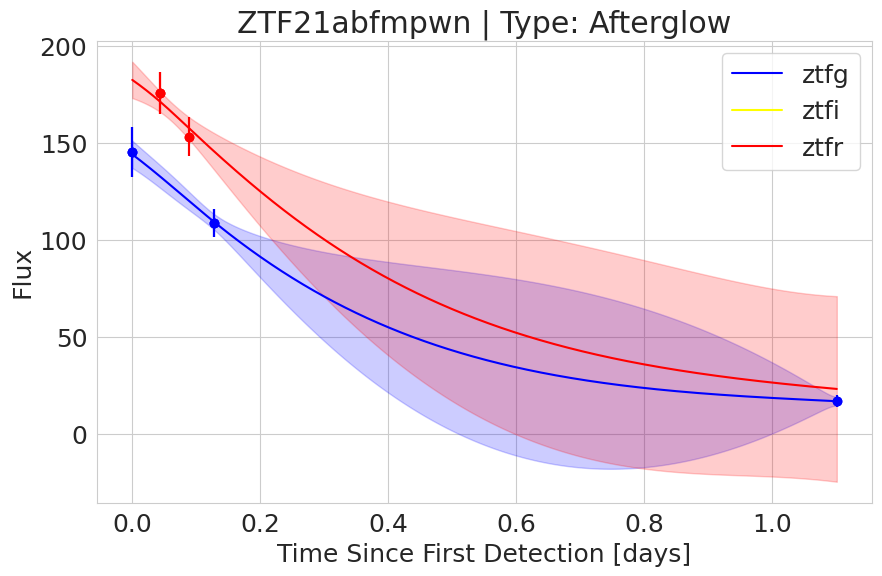

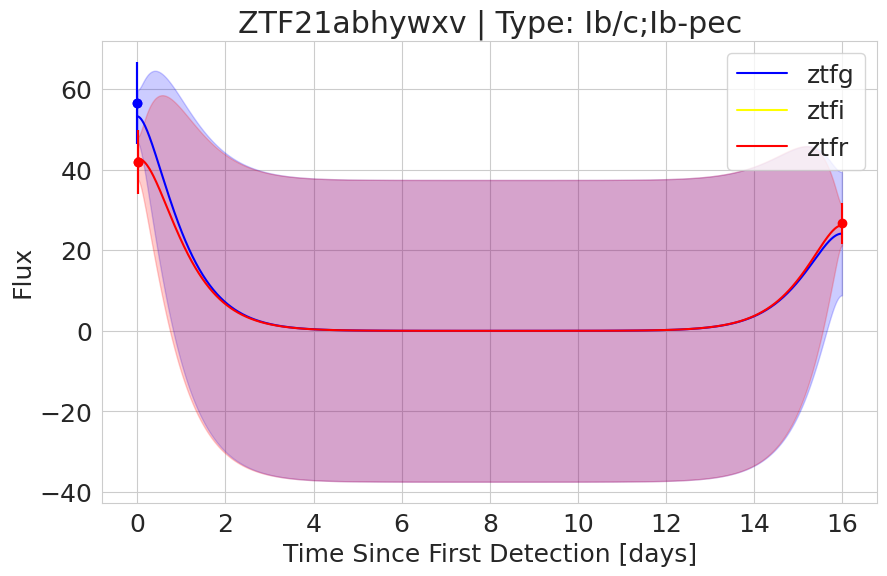

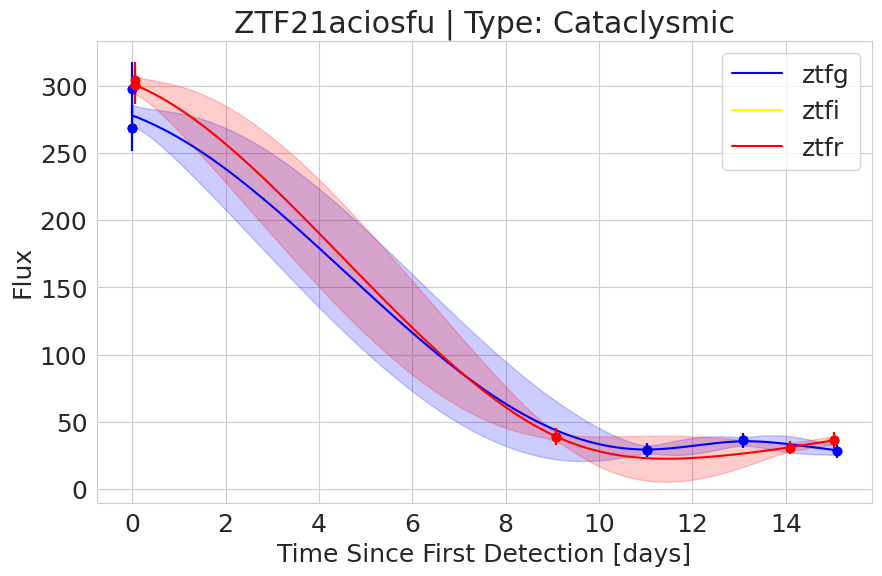

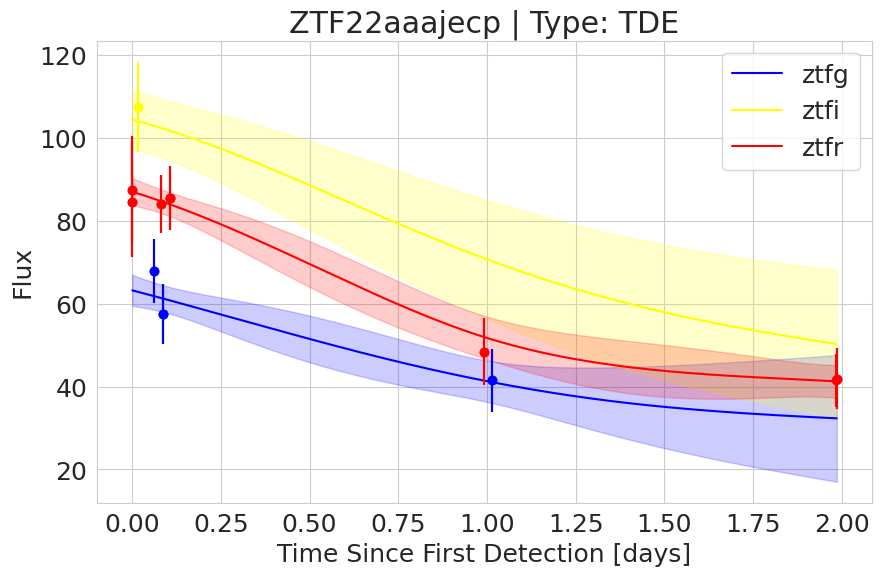

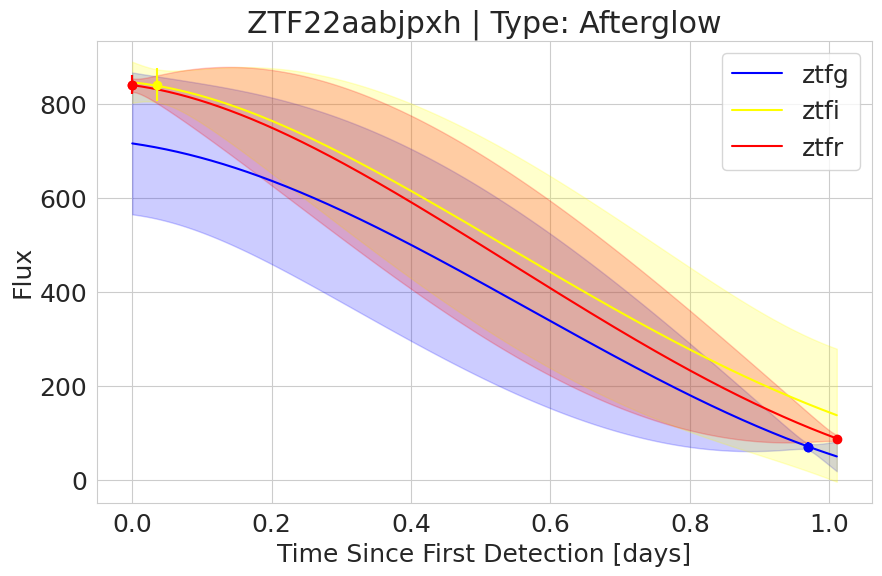

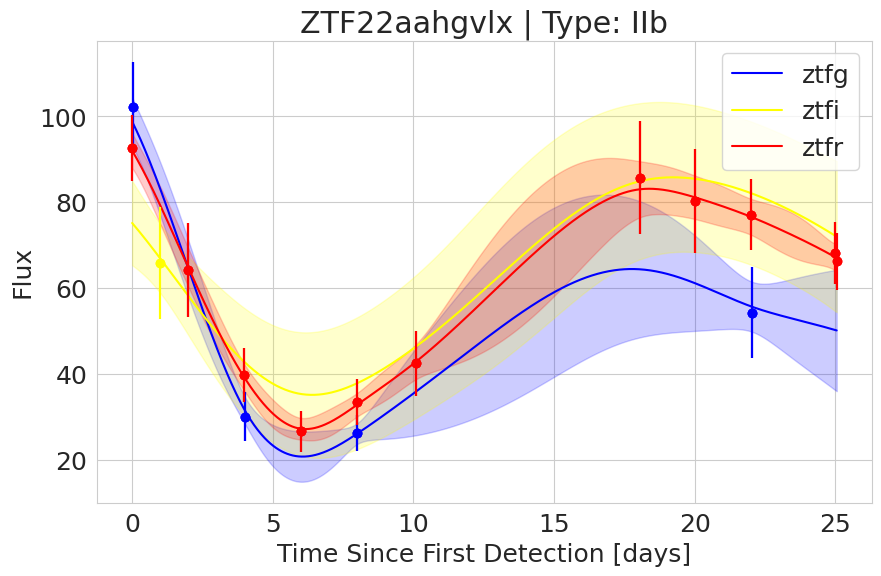

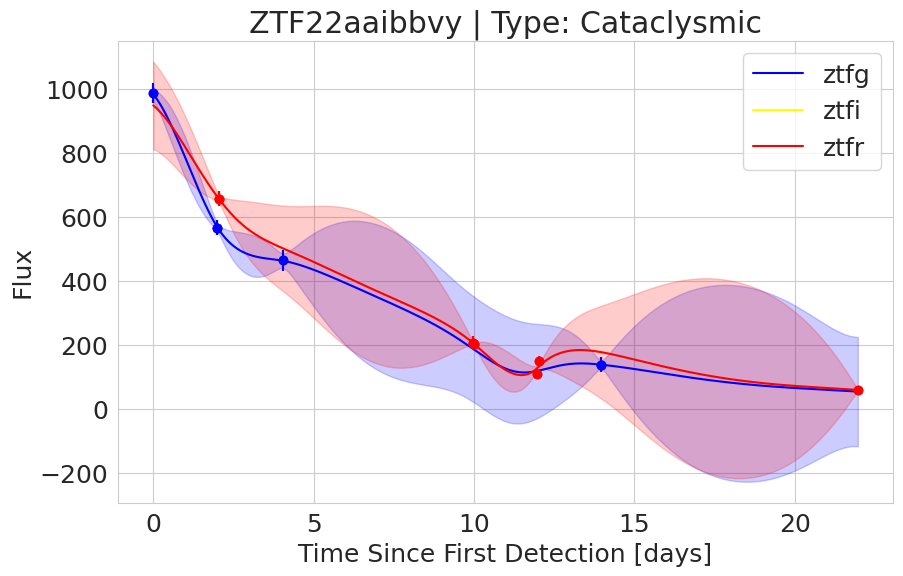

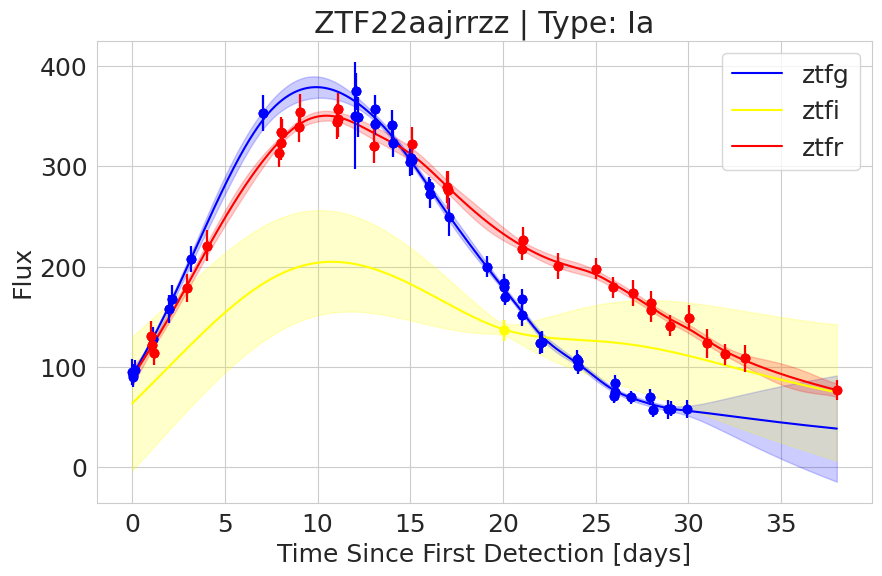

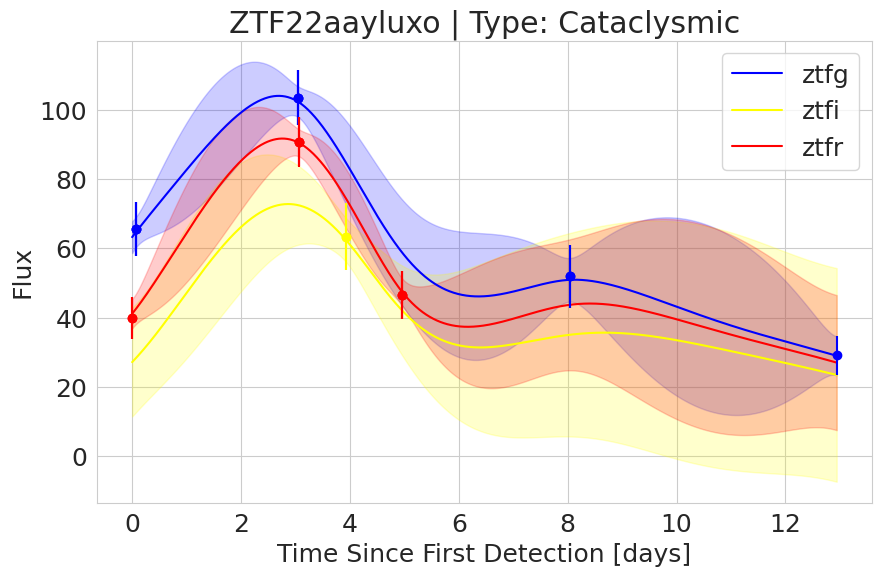

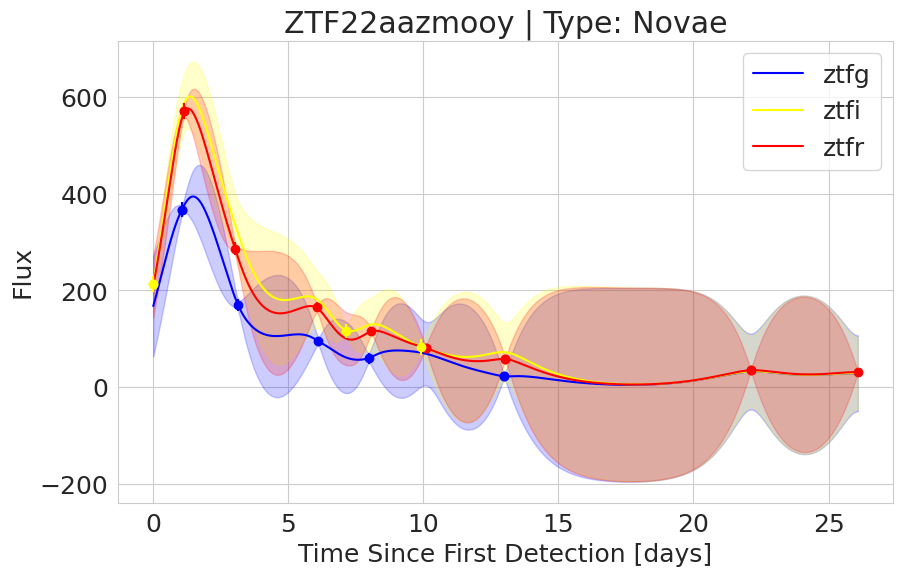

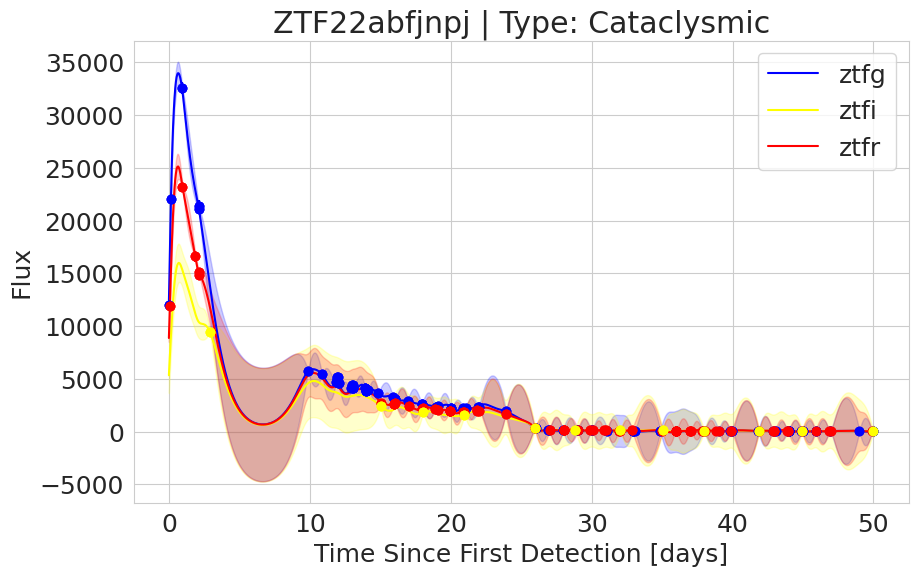

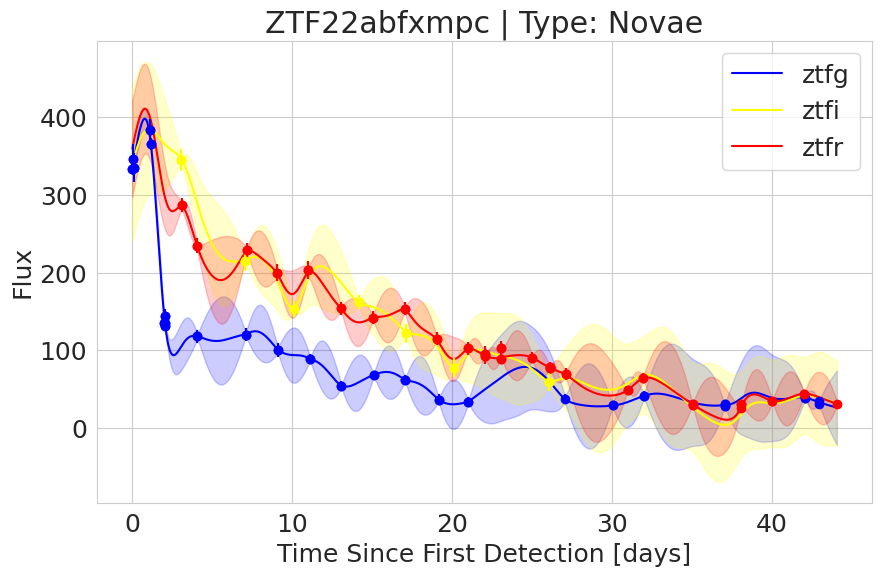

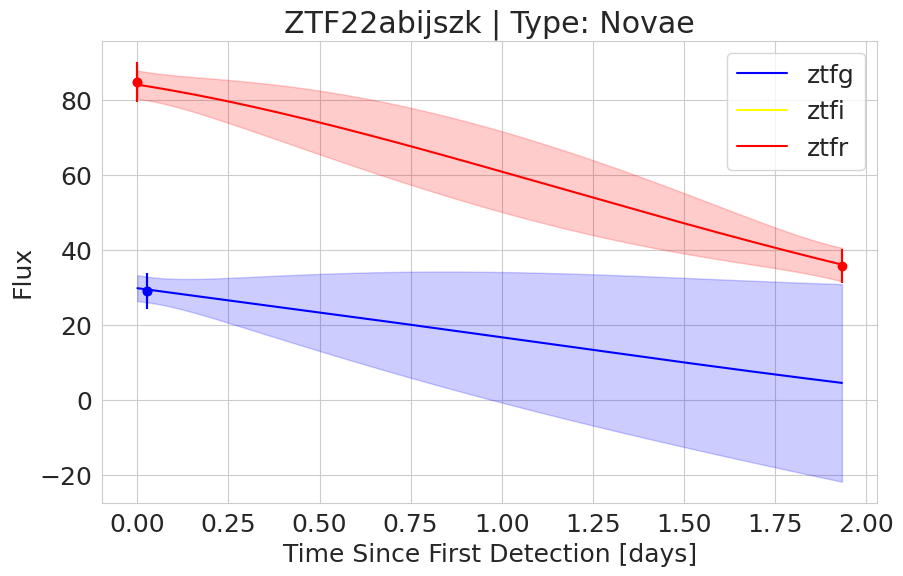

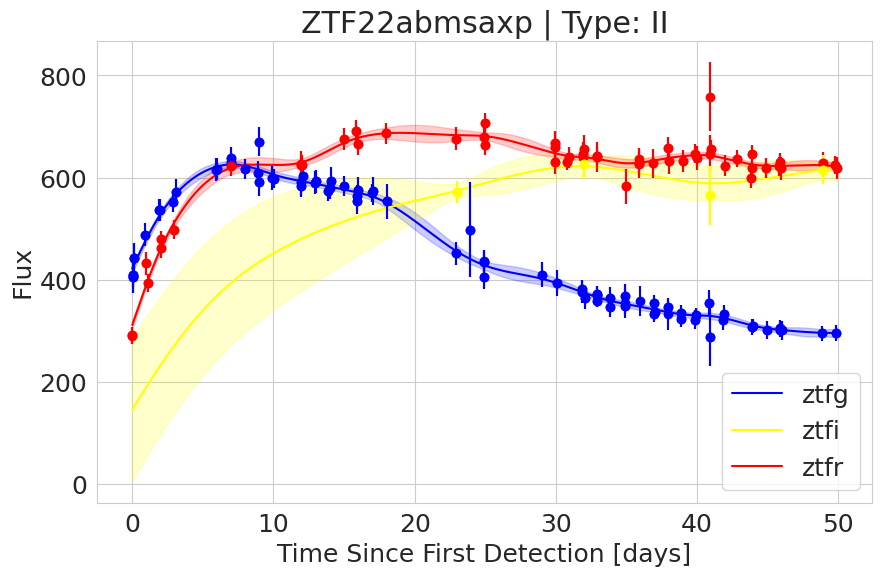

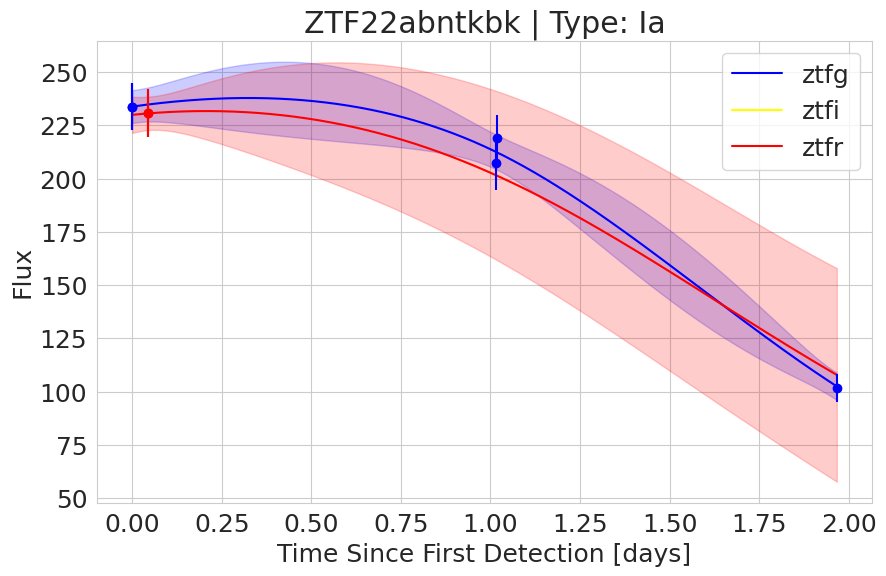

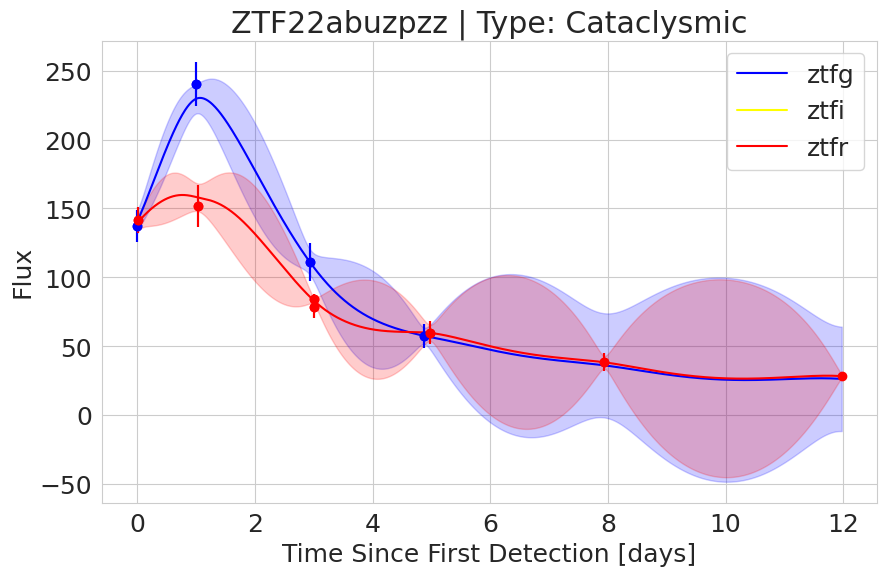

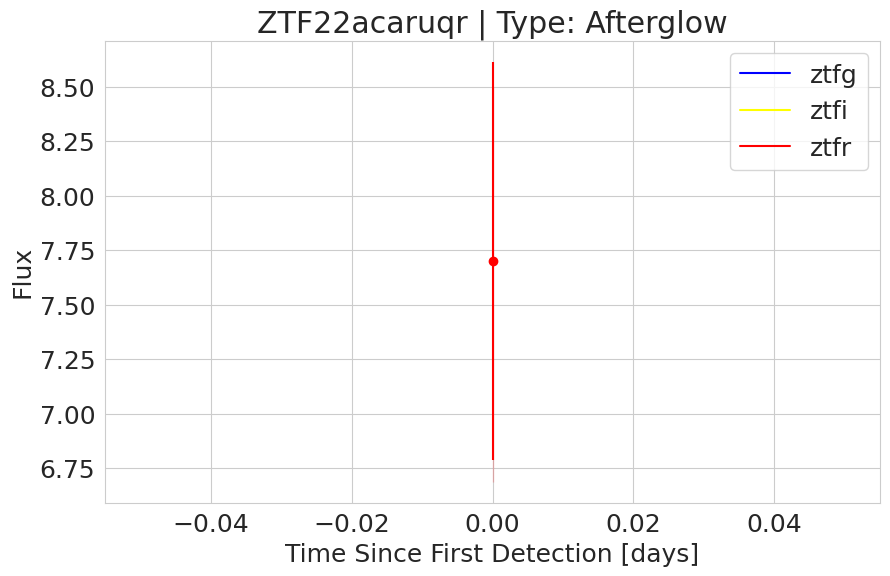

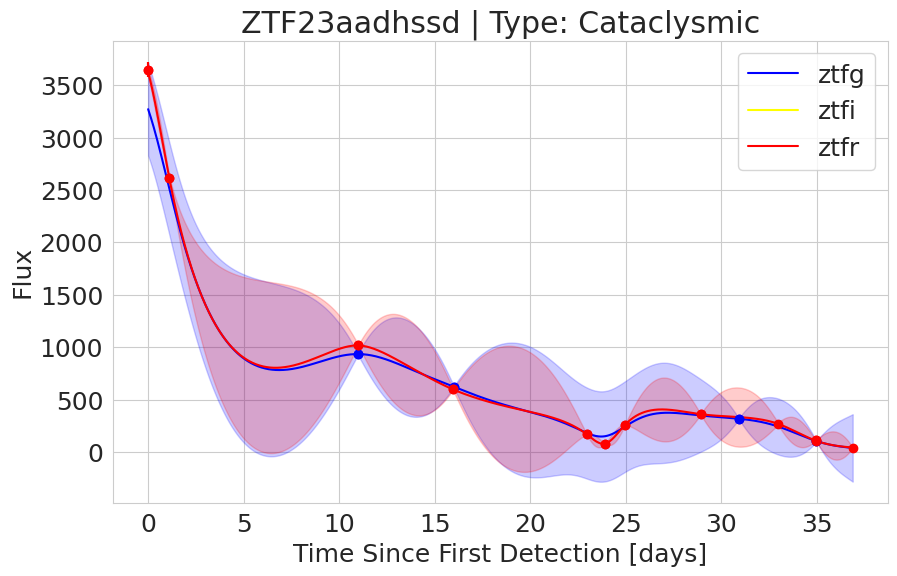

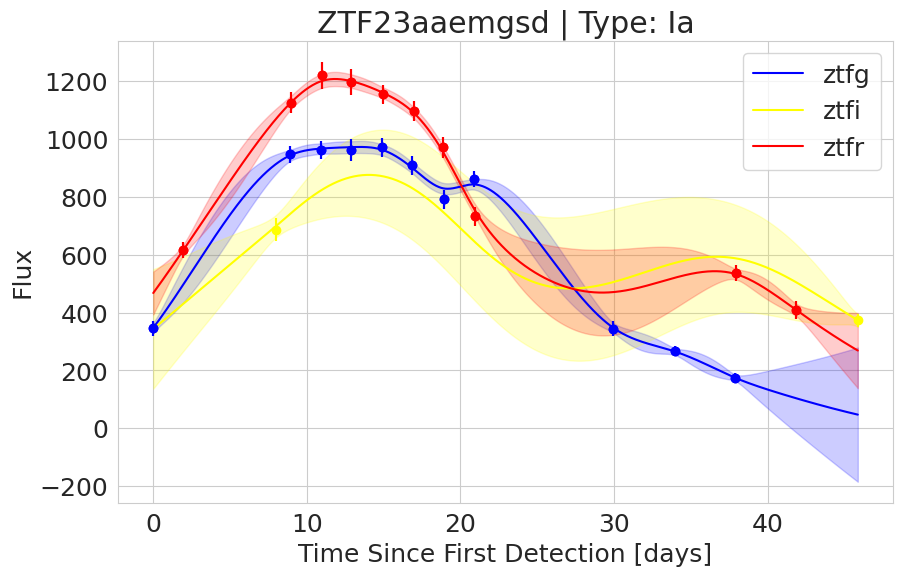

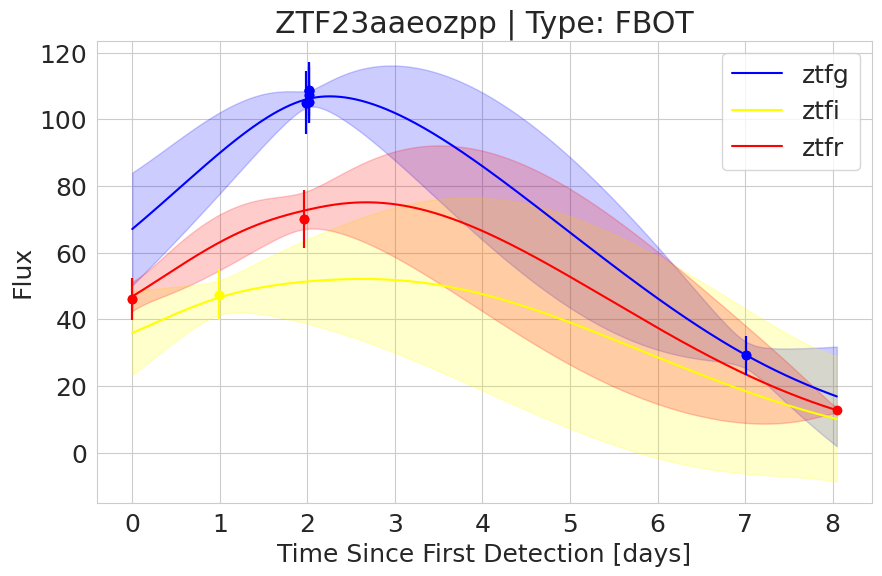

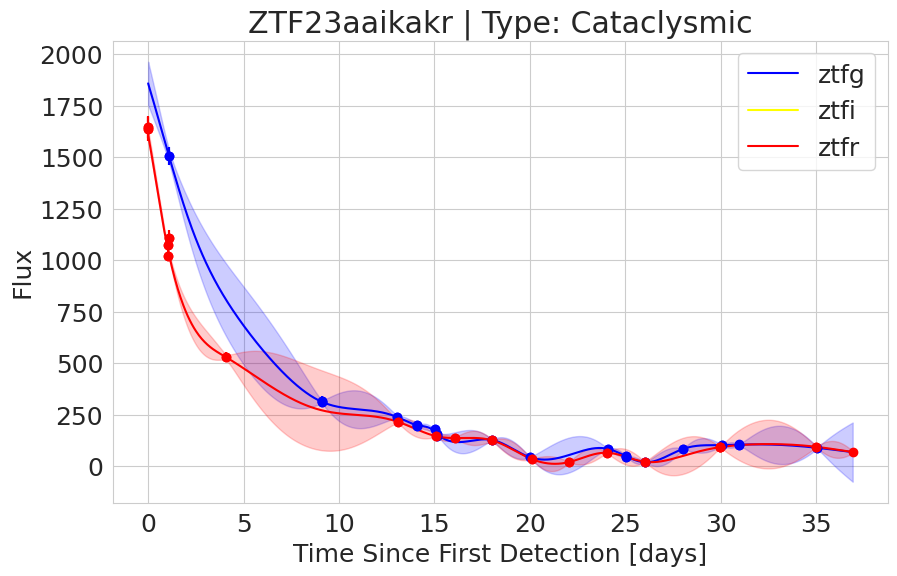

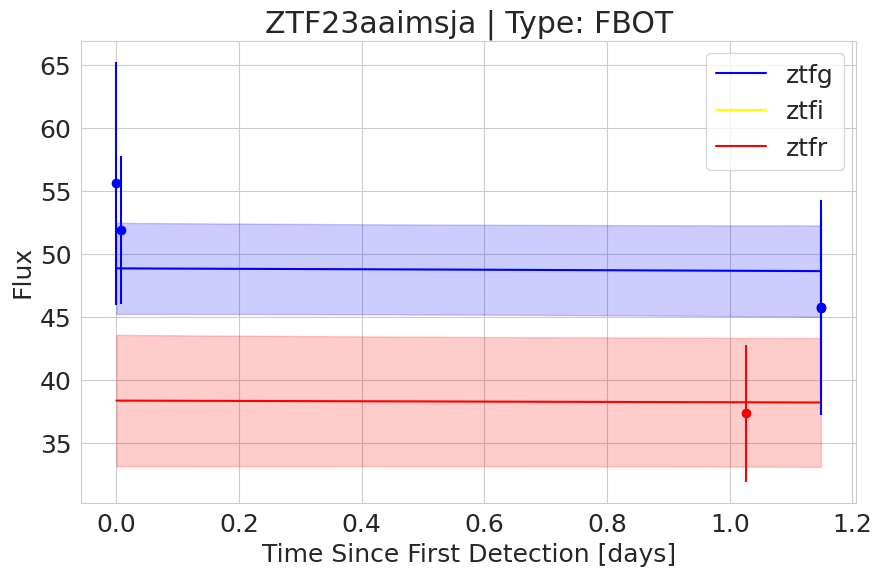

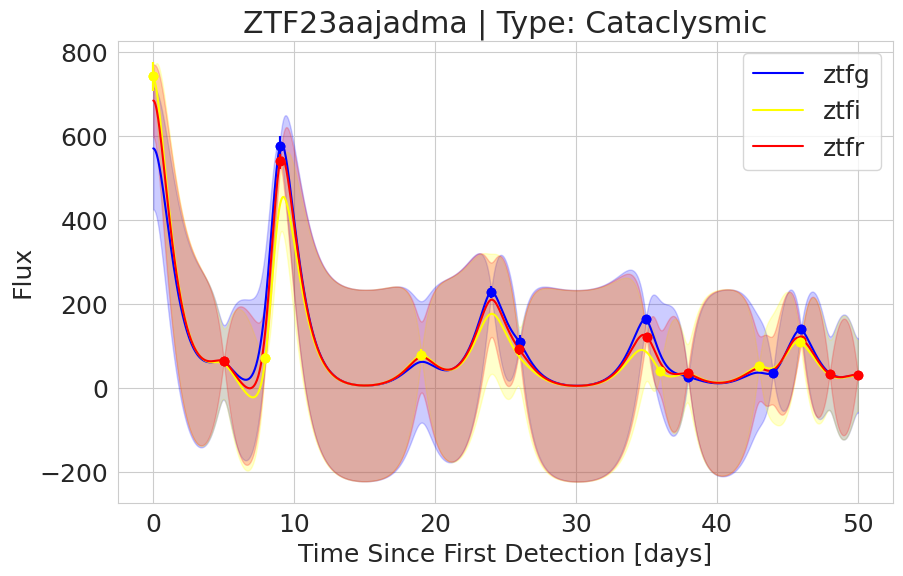

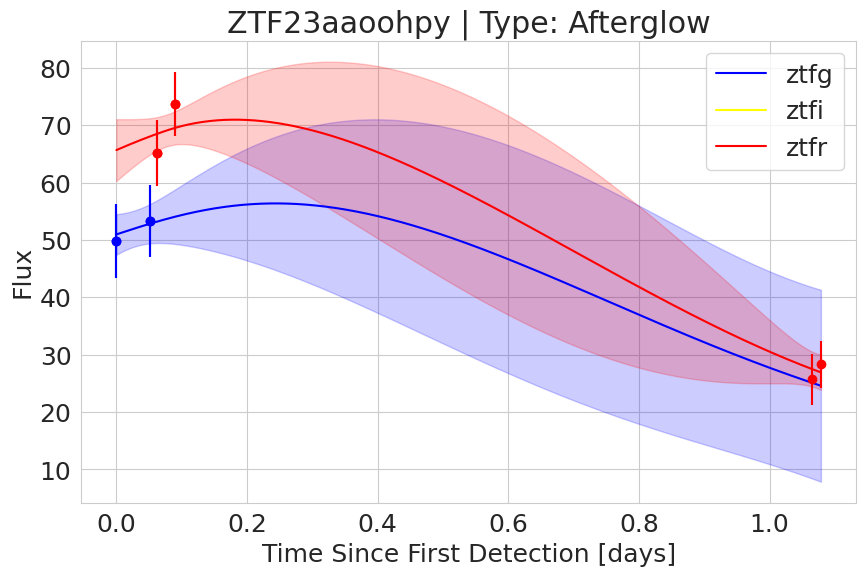

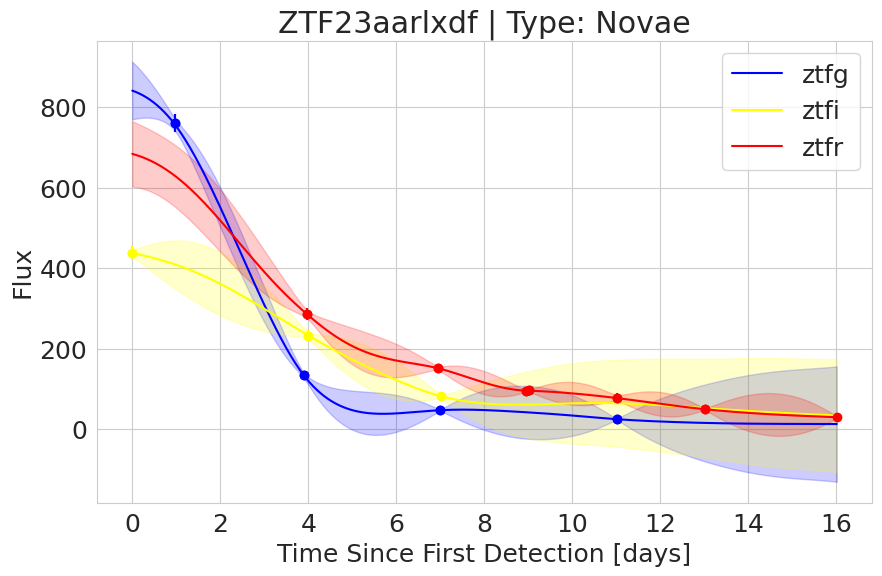

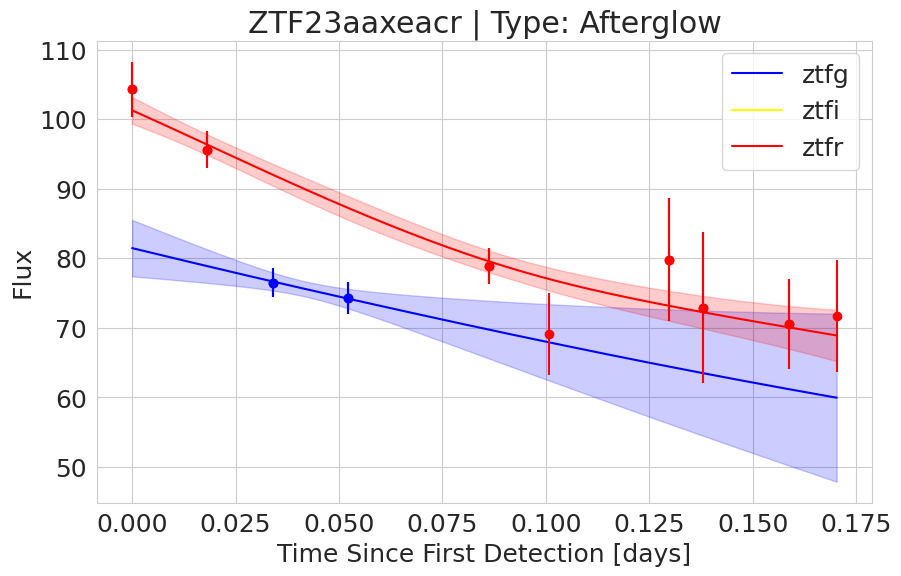

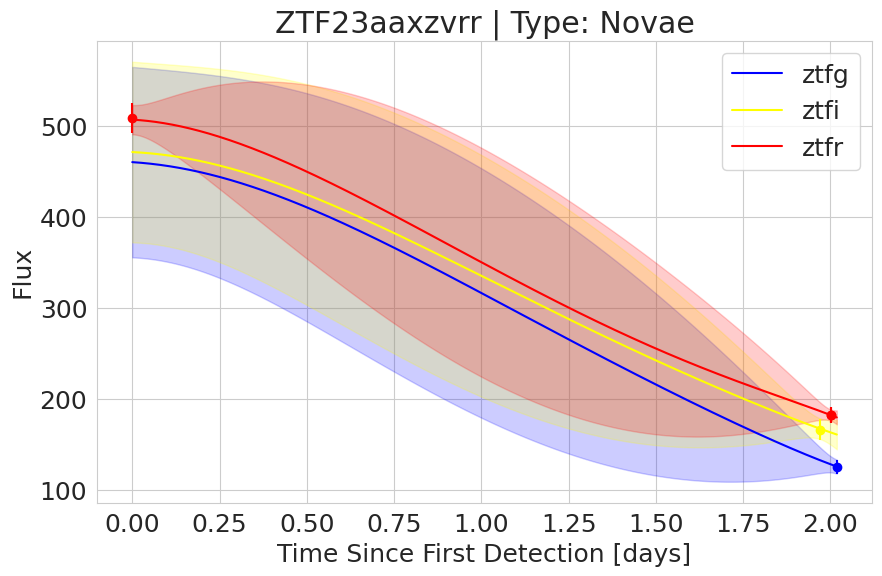

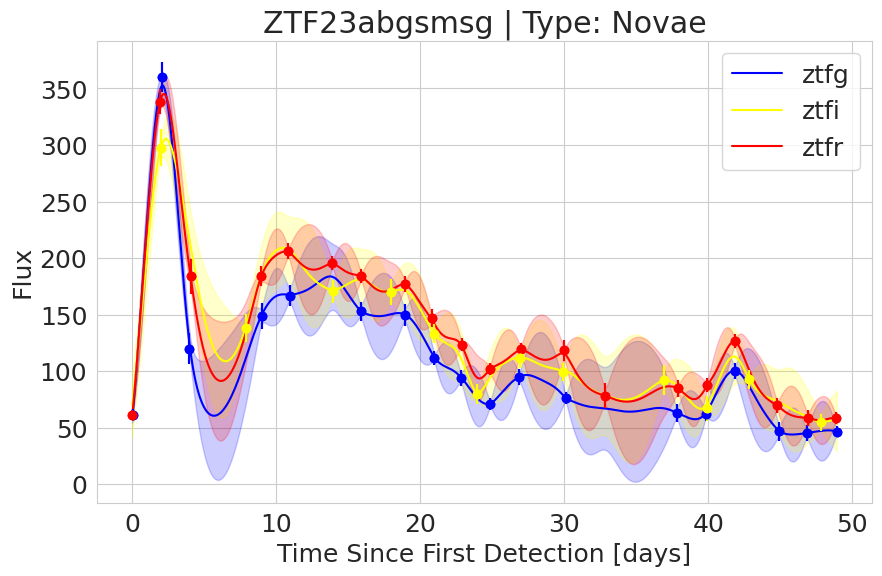

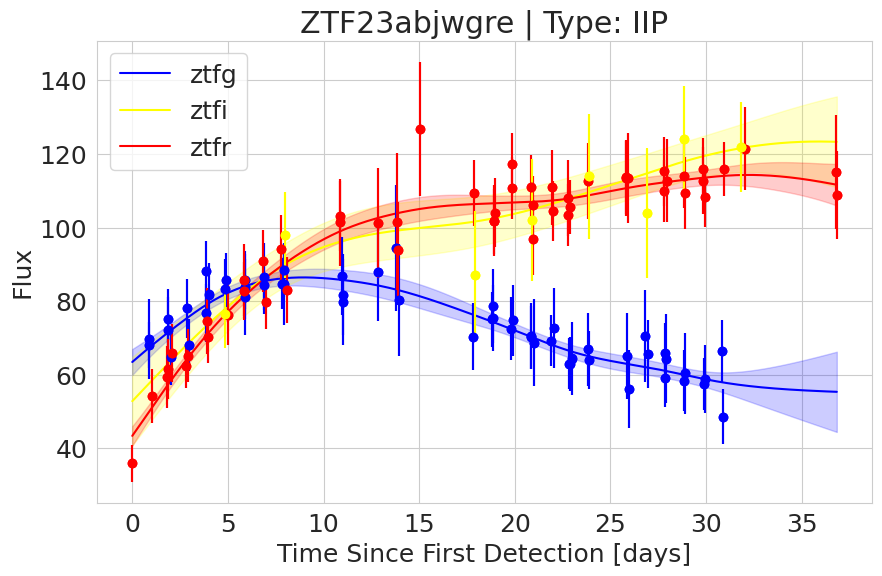

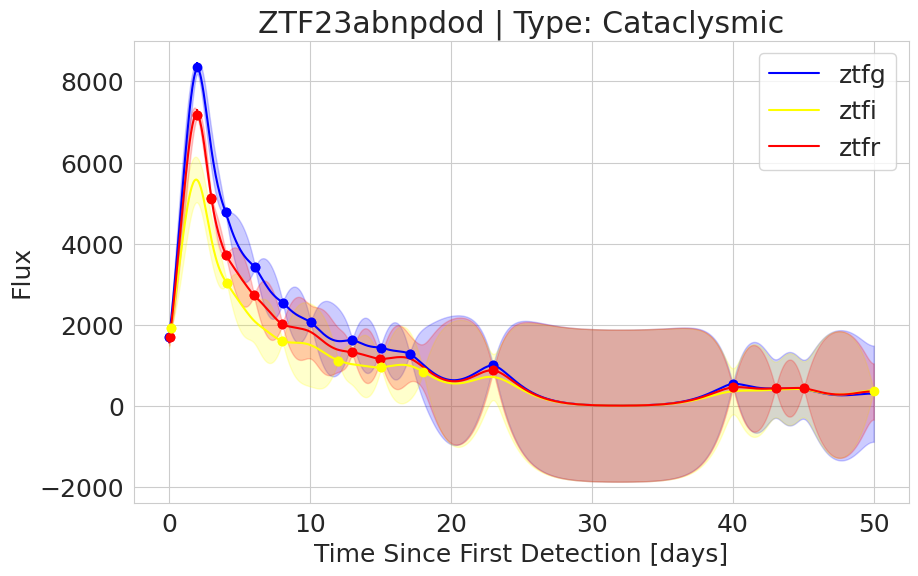

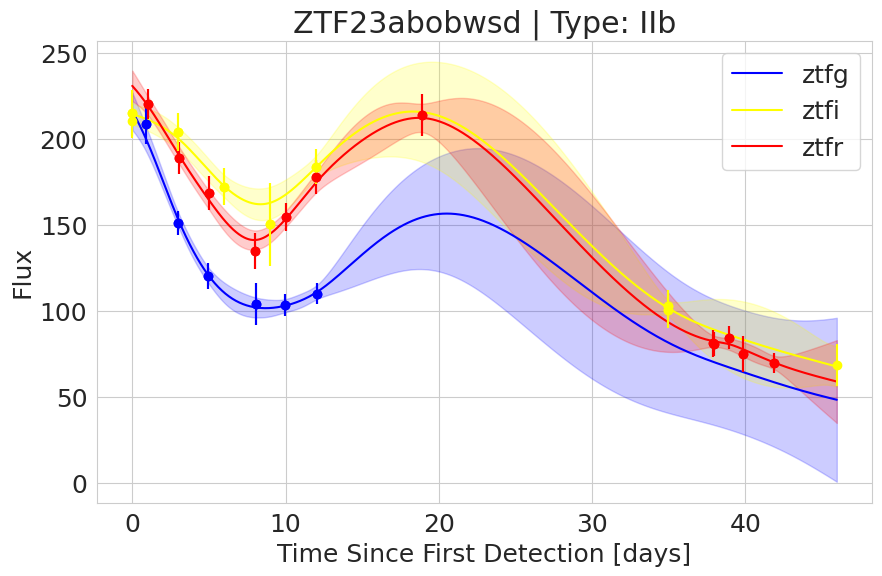

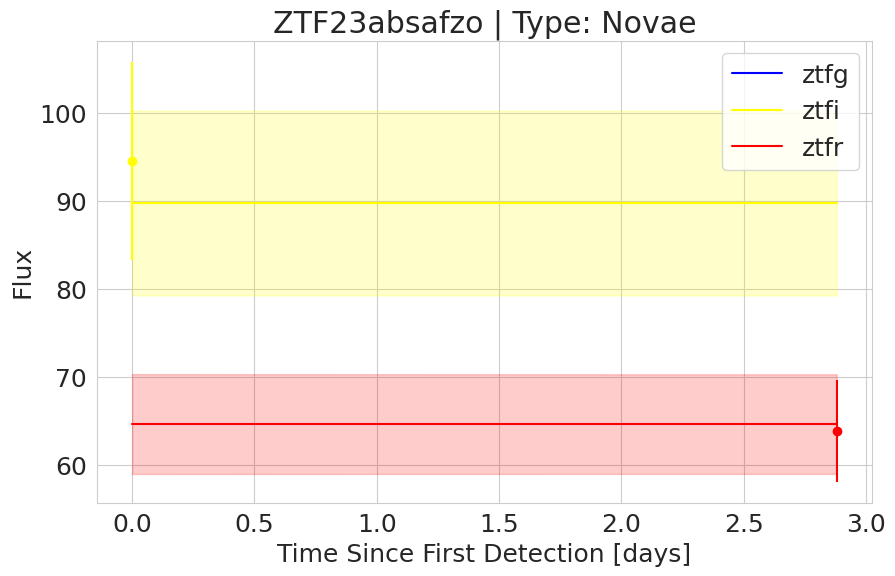

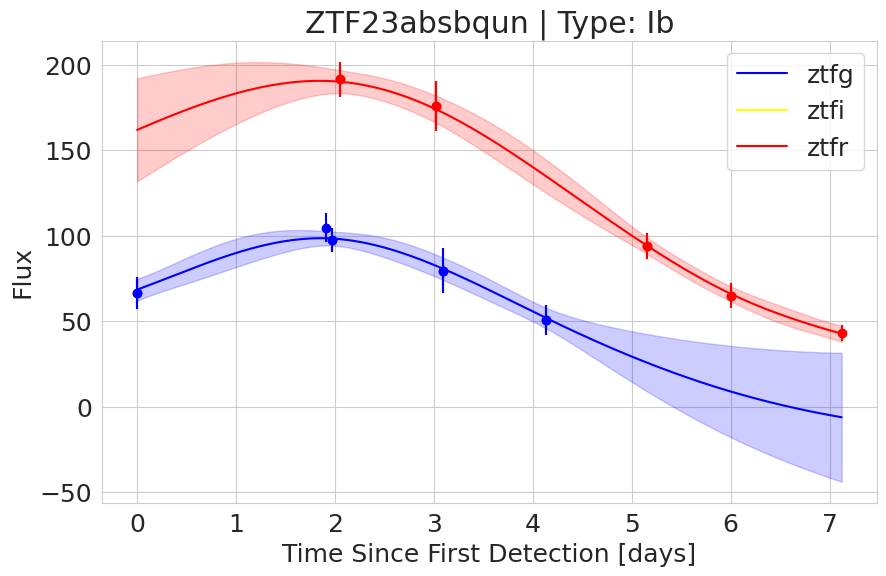

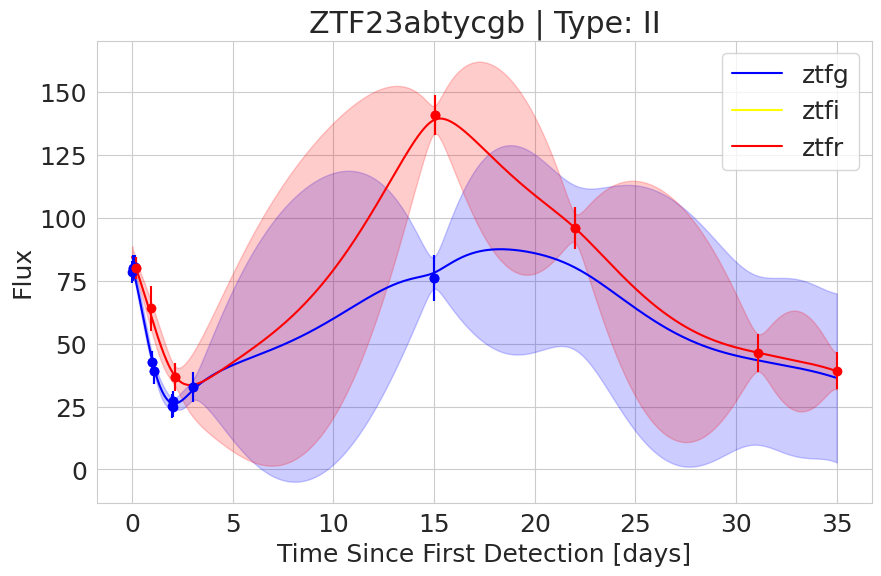

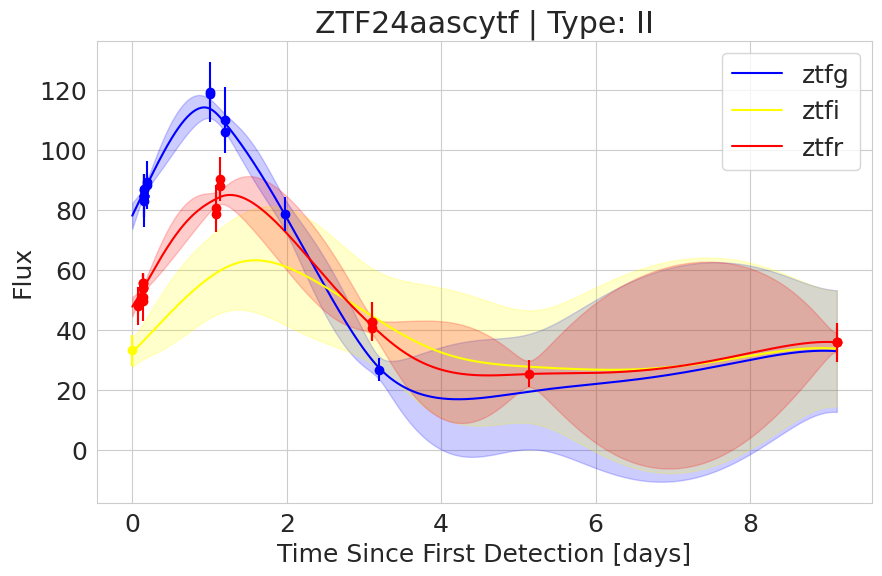

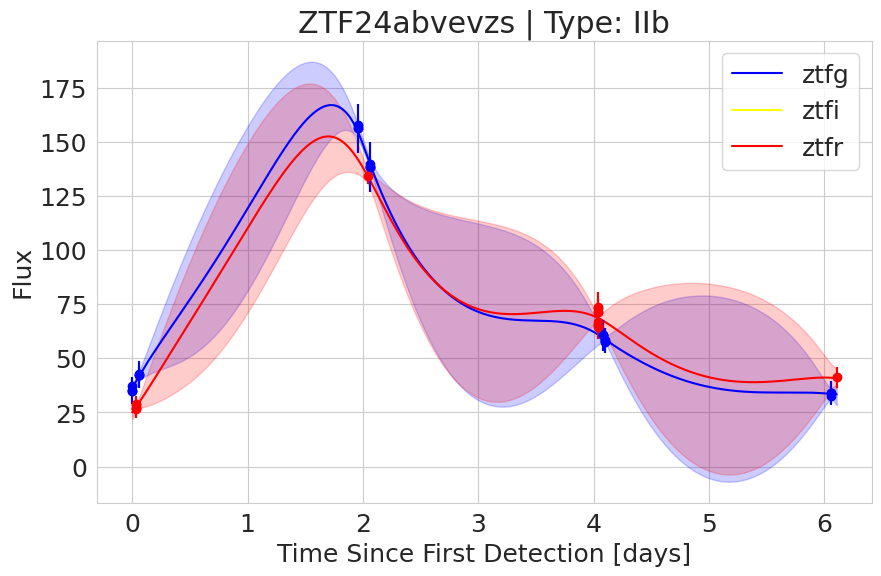

In [64]:
# sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 18})
plot_results = total_results
obj_ids = plot_results['obj_id'].unique()
broken_obj_ids = []
for obj in obj_ids:
    one_df = plot_results[plot_results['obj_id'] == obj]
    two_df = norm_df[norm_df['obj_id']==obj]
    two_df = two_df[two_df['mjd']<50]
    fi, axi = plot_gp(one_df, show_legend=False)
    axi.legend()
    axi.grid()
    for filter_name in ['ztfg', 'ztfr', 'ztfi']:
        axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
    plt.savefig(f'figures/gp_plots/{obj}.pdf')
    plt.show()

In [29]:
# question_objects = ['ZTF19abacxod', 'ZTF19abxjrge', 'ZTF21aaabrpu', 'ZTF21aaabwfu', 'ZTF21aabxjqr', 'ZTF21aapkbav', 'ZTF21aaqzrat', 'ZTF23aajadma', 'ZTF23abtycgb']
# for obj in question_objects:
#     one_df = plot_results[plot_results['obj_id'] == obj]
#     two_df = norm_df[norm_df['obj_id']==obj]
#     two_df = two_df[two_df['mjd']<50]
#     fi, axi = plot_gp(one_df, show_legend=False)
#     for filter_name in ['ztfg', 'ztfr', 'ztfi']:
#         axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
#     plt.show()

In [30]:
from astropy.coordinates import Distance
import astropy.units as u
# def absmag(m, z):
#     '''
#     Converts apparent magnitude to absolute magnitude.
    
#     Args:
#         m (float): apparent magnitude
#         z (float): redshift
#     '''
#     try:
#         z = float(z)
#     except:
#         if type(z) == str:
#             z = float(z.split('±')[0])
#             #print('converted')
#     if m is None or m is np.nan or z is None or z is np.nan:
#         return np.nan
#     else:
#         #print(z)
#         #print(type(z))
#         if z<=0:
#             d = 8178 ## https://ui.adsabs.harvard.edu/abs/2019A%26A...625L..10G/abstract
#         elif z > 0:
#             M = d = Distance(unit=u.pc, z=float(z), allow_negative=True)
#         try:
#             M = m - 5 * np.log10(d/(10*u.pc))
#         except:
#             M = np.nan
#         return M

def Norm2Mag(df):
    df_copy = df.copy()
    display(df_copy['redshift'].describe())
    for filter in ['ztfg', 'ztfr', 'ztfi']:
        df_copy[f'mag_{filter}'] = 23.9 - 2.5 * np.log10(df_copy[f'flux_{filter}'])
        df_copy[f'abs_mag_{filter}'] = absmag(df_copy[f'mag_{filter}'], df_copy['redshift'])
        #df_copy[f'abs_mag_{filter}'] = [absmag(m, z) for m, z in zip(df_copy[f'mag_{filter}'], df_copy['redshift'])]
        df_copy[f'mag_error_{filter}'] = 2.5 * df_copy[f'flux_error_{filter}'] / (df_copy[f'flux_{filter}'] * np.log(10))
    df_copy['t'] = df_copy['mjd']
    df_copy['mjd'] = df_copy['mjd'] + df_copy['mjd_0']
    # df_copy.reset_index(drop=True, inplace=True)
    return df_copy  

In [31]:
total_mag = Norm2Mag(total_results)
display(total_mag)


# # total_mag[total_mag['obj_id'] == 'ZTF18aakuewf']
# # total_mag[total_mag['mag_error_ztfg'] < 0]
# total_mag['mag_error_ztfg']

count    74001.000000
mean         0.159024
std          0.424314
min          0.000000
25%          0.001000
50%          0.027000
75%          0.056000
max          2.900000
Name: redshift, dtype: float64

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


mjd   flux_ztfg   flux_ztfi   flux_ztfr  flux_error_ztfg  \
0      57983.231000  385.374906  440.341788  404.940209        29.250027   
1      57983.239778  382.559484  438.232033  402.502588        28.789575   
2      57983.248556  379.738177  436.119876  400.065220        28.332873   
3      57983.257333  376.910979  434.005567  397.628148        27.879986   
4      57983.266111  374.077886  431.889351  395.191413        27.430981   
...             ...         ...         ...         ...              ...   
73996  60652.513689   33.493383         NaN   40.961798         3.488673   
73997  60652.519801   33.463261         NaN   40.930338         3.842217   
73998  60652.525913   33.432509         NaN   40.895906         4.235472   
73999  60652.532025   33.401076         NaN   40.858402         4.657035   
74000  60652.538137   33.368917         NaN   40.817727         5.098662   

       flux_error_ztfi  flux_error_ztfr      type        obj_id         mjd_0  \
0            17.182907        24.797305  Kilonova     AT2017gfo  57983.231000   
1            16.890215        24.361032  Kilonova     AT2017gfo  57983.231000   
2            16.606597        23.927709  Kilonova     AT2017gfo  57983.231000   
3            16.332054        23.497397  Kilonova     AT2017gfo  57983.231000   
4            16.066587        23.070161  Kilonova     AT2017gfo  57983.231000   
...                ...              ...       ...           ...           ...   
73996              NaN         5.252959       IIb  ZTF24abvevzs  60646.432303   
73997              NaN         5.054402       IIb  ZTF24abvevzs  60646.432303   
73998              NaN         4.909244       IIb  ZTF24abvevzs  60646.432303   
73999              NaN         4.823773       IIb  ZTF24abvevzs  60646.432303   
74000              NaN         4.802653       IIb  ZTF24abvevzs  60646.432303   

       ...   mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
0      ...  17.435291    -15.778388        0.082408  17.381523    -15.832157   
1      ...  17.443253    -15.770427        0.081707  17.388078    -15.825601   
2      ...  17.451289    -15.762390        0.081009  17.394673    -15.819007   
3      ...  17.459403    -15.754277        0.080312  17.401307    -15.812372   
4      ...  17.467595    -15.746085        0.079617  17.407981    -15.805698   
...    ...        ...           ...             ...        ...           ...   
73996  ...  20.087602    -15.921953        0.113090  19.869052    -16.140503   
73997  ...  20.088579    -15.920976        0.124663  19.869887    -16.139669   
73998  ...  20.089578    -15.919978        0.137549  19.870800    -16.138755   
73999  ...  20.090599    -15.918957        0.151382  19.871797    -16.137759   
74000  ...  20.091645    -15.917911        0.165897  19.872878    -16.136678   

       mag_error_ztfr   mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
0            0.066487  17.290525    -15.923154        0.042367  0.000000  
1            0.065713  17.295740    -15.917940        0.041846  0.008778  
2            0.064937  17.300985    -15.912694        0.041343  0.017556  
3            0.064160  17.306262    -15.907418        0.040857  0.026333  
4            0.063382  17.311569    -15.902111        0.040390  0.035111  
...               ...        ...           ...             ...       ...  
73996        0.139235        NaN           NaN             NaN  6.081386  
73997        0.134075        NaN           NaN             NaN  6.087498  
73998        0.130334        NaN           NaN             NaN  6.093610  
73999        0.128183        NaN           NaN             NaN  6.099721  
74000        0.127749        NaN           NaN             NaN  6.105833  

[74001 rows x 21 columns]

In [ ]:
total_mag.to_csv('gp_objects.csv', index=False)

In [33]:
# af_df = total_mag[total_mag['type'].str.contains('Afterglow')]
# fig, ax = plt.subplots()
# for obj in af_df['obj_id'].unique():
#     print(obj)
#     obj_df = af_df[af_df['obj_id'] == obj]
#     #obj_df = obj_df[obj_df['mjd'] < 50]
#     ax.plot(obj_df['mjd']-obj_df['mjd'].min(), obj_df['mag_ztfg']-obj_df['mag_ztfg'].min(), label=obj_df['type'].values[0])
    
# ax.legend()